# Sparkify - Prediction of User Churn

**Project Overview:** This project tackles the **prediction of user churn** after data wrangling, exploratory data analysis, feature engineering as well as modeling and tuning different machine learning classification algorithms. The broader context involves the **cluster-computing framework Spark** in order to expand the methods to **big data** using the Spark ML DataFrame-based API.

The project uses datasets from a simulated audio streaming service provider **Sparkify** containing events from user interaction with their product. A small subset of events is used in this notebook to develop the methods prior to deployment in the cloud. 

**Problem Statement:** Users of the audio streaming service Sparkify can manage their involvement by upgrading from a free to paid version, downgrading vice versa or canceling the service altogether. The problem investigated in this project will be to predict user churn: the identification of users who have a higher probability of canceling the service in the near future. From a business perspective, a clean identification of user churn enables insights into the **driving factors of adverting from the service**. Furthermore, it motivates **countermeasures targeted to a specific user group**, such as providing incentives for staying involved.

This problem is solved by tuning and contrasting different machine learning classification algorithms that should distinguish churn users from non-churn users to find the most suited classification model.

**Metrics for Model Performance:** Measurement of model performance is done by **overall model F1 score, accuracy** and **single feature importance**. The focus for the overall model performance should be on the F1 score as a weighted average of Precision and Recall<sup>1</sup> instead of accuracy in this scenario because the label "churn" is imbalanced in the dataset (23% churn). Single feature importance gives insight into strong and weak predictors of churn leading to a more precise understanding of user churn in the first place and triggering improved feature engineering for refining the model in the future.

## Table of Contents
1. [Load and Clean Dataset](#load-clean-dataset)
    - [Investigate Duplicate Rows](#investigate-duplicate-rows)
    - [Investigate Session ID & User ID](#investigate-session-id-user-id)
    - [Investigate Length](#investigate-length)
    - [Convert Timestamp to Datetime & Date](#convert-timestamp-to-datetime-date)
    - [Extract Weekday from Timestamp](#extract-weekday-from-timestamp)
    - [Extract Year, Month & Day from Date](#extract-year-month-day-from-date)
    - [Extract Hour from Datetime](#extract-hour-from-datetime)
    - [Extract Day Half from Hour](#extract-day-half-from-hour)
    - [Extract Days Since Registration from Date & Registration Date](#extract-days-since-registration-from-date-registration-date)
    - [Extract Browser & Device/Operating System from User Agent](#extract-browser-device-os-from-user-agent)
    - [Extract State from Location](#extract-state-from-location)
2. [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Pages & Method](#pages-method)
    - [Browser](#browser)
    - [Device/OS](#device-os)
    - [Level](#level)
    - [Gender](#gender)
    - [State](#state)
    - [Unique Sessions per User](#unique-sessions-per-user)
    - [Items per Session](#items-per-session)
    - [Length per Item or Session](#length-per-item-session)
    - [Days Since Registration](#days-since-registration)
    - [Seasonality](#seasonality)
    - [Time Series of Page Types](#time-series-page-types)
    - [Weekday Time Series of Page Types](#weekday-time-series-page-types)
    - [Hourly Time Series of Page Types](#hourly-time-series-page-types)
    - [Time Series of Registration](#time-series-registration)
    - [Weekday Time Series of Registration](#weekday-time-series-registration)
    - [Hourly Time Series of Registration](#hourly-time-series-registration)
    - [LABEL | Churn Definition](#churn-definition)
    - [Pages](#pages)
    - [Browser](#browser-2)
    - [Device/OS](#device-os-2)
    - [Level](#level-2)
    - [Gender](#gender-2)
    - [State](#state-2)
    - [Unique Sessions per User](#unique-sessions-per-user-2)
    - [Items per Session](#items-per-session-2)
    - [Length per Item or Session](#length-per-item-session-2)
    - [Days Since Registration](#days-since-registration-2)
    - [Time Series](#time-series)
    - [Weekday Time Series](#weekday-time-series)
    - [Hourly Time Series](#hourly-time-series)
3. [Feature Engineering](#feature-engineering)
    - [Categorical Features](#categorical-features)
    - [Numerical Features](#numerical-features)
    - [Labels](#labels)
    - [Merge Features & Labels](#merge-features-labels)
4. [Modeling](#modeling)
    - [Logistic Regression](#logistic-regression)
    - [Random Forest Classifier](#random-forest-classifier)
    - [Gradient-Boosted Tree Classifier](#gradient-boosted-tree-classifier)
    - [Model Comparison](#model-comparison)
    - [Hyperparameter Tuning](#hyperparameter-tuning)
    - [Logistic Regression - CV](#logistic-regression-cv)
    - [Random Forest Classifier - CV](#random-forest-classifier-cv)
    - [Gradient-Boosted Tree Classifier - CV](#gradient-boosted-tree-classifier-cv)
    - [Model Comparison - CV](#model-comparison-cv)
5. [Discussion](#discussion)

In [1]:
# import libraries
from datetime import datetime
from time import time

# pyspark.sql
from pyspark import SparkContext
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as f
from pyspark.sql.types import IntegerType

# pyspark.ml
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, VectorAssembler, MinMaxScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create Spark session & Spark context
spark = SparkSession.builder \
    .master('local') \
    .appName('Sparkify Model') \
    .getOrCreate()

## Load and Clean Dataset <a class="anchor" id="load-clean-dataset"></a>

In [3]:
df = spark.read.json('mini_sparkify_event_data.json') # mini dataset to run code on local machine
df.persist() # lazy evaluation

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Investigate Duplicate Rows <a class="anchor" id="investigate-duplicate-rows"></a>

In [6]:
entire_df = df.count()
no_duplicate_df = df.dropDuplicates().count()

if entire_df > no_duplicate_df:
    raise ValueError('The dataset has duplicates')
else:
    print('The dataset has no duplicates on {} rows.'.format(entire_df)) 

The dataset has no duplicates on 286500 rows.


### Investigate Session ID & User ID <a class="anchor" id="investigate-session-id-user-id"></a>

In [9]:
id_list = ['sessionId','userId']

print('The dataset has {} rows.\n'.format(df.count()))

for idx in id_list:
    # min and max values
    df.agg(f.min(f.col(idx)), f.max(f.col(idx))).show()
    # count and share of missing values
    null_count = df.where((df[idx].isNull()) | (df[idx] == '')).count()
    null_share = (null_count/df.count())*100
    print('{} rows ({}%) have missing {}.\n'.format(null_count, "{:.2f}".format(null_share), idx))

The dataset has 286500 rows.

+--------------+--------------+
|min(sessionId)|max(sessionId)|
+--------------+--------------+
|             1|          2474|
+--------------+--------------+

0 rows (0.00%) have missing sessionId.

+-----------+-----------+
|min(userId)|max(userId)|
+-----------+-----------+
|           |         99|
+-----------+-----------+

8346 rows (2.91%) have missing userId.



In [12]:
# page visits for rows with missing userId
df.select(['userId','page','ts']) \
  .where(f.col('userId')=='') \
  .groupby('page') \
  .count() \
  .sort(f.desc('count')) \
  .show()

+-------------------+-----+
|               page|count|
+-------------------+-----+
|               Home| 4375|
|              Login| 3241|
|              About|  429|
|               Help|  272|
|           Register|   18|
|              Error|    6|
|Submit Registration|    5|
+-------------------+-----+



**Conclusion:** Since the events with missing user IDs seem to be attributed to users that are not logged in (most of these events are located at pages "Home" & "Login"), these events will be excluded from further analyses.

In [13]:
# drop rows with missing userId
df_clean = df.filter(df['userId'] != '')
print('The clean dataset is reduced to {} rows.\n'.format(df_clean.count()))

The clean dataset is reduced to 278154 rows.



### Investigate Length <a class="anchor" id="investigate-length"></a>

In [15]:
# filter for pages with length = None
no_length_pages = df_clean.filter(df_clean.length.isNull()) \
                          .select(f.col('page') \
                          .alias('no_length_pages')) \
                          .dropDuplicates()

# get a list of possible pages that could be visited
all_pages = df_clean.select('page').dropDuplicates()

print('These pages are connected to empty length values:')
for row in list(no_length_pages.sort('page').collect()):
    print(row[0])

# find values in all_pages that are not in no_length_pages
# these are the pages that are always connected to a length value
for row in set(all_pages.collect()) - set(no_length_pages.collect()):
    print('\nThese pages always have the column length filled:\n' + row.page)

These pages are connected to empty length values:
About
Add Friend
Add to Playlist
Cancel
Cancellation Confirmation
Downgrade
Error
Help
Home
Logout
Roll Advert
Save Settings
Settings
Submit Downgrade
Submit Upgrade
Thumbs Down
Thumbs Up
Upgrade

These pages always have the column length filled:
NextSong


**Conclusion:** Data seems to be valid since the empty length values are always connected to pages that are **not** playing songs. No cleaning necessary.

### Convert Timestamp to Datetime & Date <a class="anchor" id="convert-timestamp-to-datetime-date"></a>

In [18]:
# user defined function to convert timestamp to datetime
datetime_converter = f.udf(lambda x: datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

# create new column 'datetime' by applying datetime_converter to column 'ts'
df_clean = df_clean.withColumn('datetime', datetime_converter(df_clean['ts']))
df_clean = df_clean.withColumn('registration_datetime', datetime_converter(df_clean['registration']))

# create new column 'date' by splitting the column 'datetime' by space
df_clean = df_clean.withColumn('date', f.split('datetime',' ')[0])
df_clean = df_clean.withColumn('registration_date', f.split('registration_datetime',' ')[0])

df_clean.select('ts','datetime','date', 'registration', 'registration_datetime', 'registration_date').show(5)

+-------------+-------------------+----------+-------------+---------------------+-----------------+
|           ts|           datetime|      date| registration|registration_datetime|registration_date|
+-------------+-------------------+----------+-------------+---------------------+-----------------+
|1538352117000|2018-10-01 00:01:57|2018-10-01|1538173362000|  2018-09-28 22:22:42|       2018-09-28|
|1538352180000|2018-10-01 00:03:00|2018-10-01|1538331630000|  2018-09-30 18:20:30|       2018-09-30|
|1538352394000|2018-10-01 00:06:34|2018-10-01|1538173362000|  2018-09-28 22:22:42|       2018-09-28|
|1538352416000|2018-10-01 00:06:56|2018-10-01|1538331630000|  2018-09-30 18:20:30|       2018-09-30|
|1538352676000|2018-10-01 00:11:16|2018-10-01|1538173362000|  2018-09-28 22:22:42|       2018-09-28|
+-------------+-------------------+----------+-------------+---------------------+-----------------+
only showing top 5 rows



### Extract Weekday from Timestamp <a class="anchor" id="extract-weekday-from-timestamp"></a>

In [19]:
# user defined function to extract weekday from timestamp
weekday_converter = f.udf(lambda x: datetime.weekday(datetime.strptime(datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"), '%Y-%m-%d %H:%M:%S')))

# create new column 'weekday' by applying weekday_converter to column 'ts'
df_clean = df_clean.withColumn('weekday', weekday_converter(df_clean['ts']))
df_clean = df_clean.withColumn('registration_weekday', weekday_converter(df_clean['registration']))

df_clean.select('ts','date','weekday', 'registration', 'registration_date','registration_weekday').show(5)

+-------------+----------+-------+-------------+-----------------+--------------------+
|           ts|      date|weekday| registration|registration_date|registration_weekday|
+-------------+----------+-------+-------------+-----------------+--------------------+
|1538352117000|2018-10-01|      0|1538173362000|       2018-09-28|                   4|
|1538352180000|2018-10-01|      0|1538331630000|       2018-09-30|                   6|
|1538352394000|2018-10-01|      0|1538173362000|       2018-09-28|                   4|
|1538352416000|2018-10-01|      0|1538331630000|       2018-09-30|                   6|
|1538352676000|2018-10-01|      0|1538173362000|       2018-09-28|                   4|
+-------------+----------+-------+-------------+-----------------+--------------------+
only showing top 5 rows



### Extract Year, Month & Day from Date <a class="anchor" id="extract-year-month-day-from-date"></a>

In [20]:
# create new columns 'year', 'month' & 'day' by splitting the column 'date' by hyphen
df_clean = df_clean.withColumn('year', f.split('date','-')[0])
df_clean = df_clean.withColumn('month', f.split('date','-')[1])
df_clean = df_clean.withColumn('day', f.split('date','-')[2])
df_clean = df_clean.withColumn('registration_year', f.split('registration_date','-')[0])
df_clean = df_clean.withColumn('registration_month', f.split('registration_date','-')[1])
df_clean = df_clean.withColumn('registration_day', f.split('registration_date','-')[2])

df_clean.select('datetime','year','month','day','registration_datetime','registration_year','registration_month','registration_day').show(5)

+-------------------+----+-----+---+---------------------+-----------------+------------------+----------------+
|           datetime|year|month|day|registration_datetime|registration_year|registration_month|registration_day|
+-------------------+----+-----+---+---------------------+-----------------+------------------+----------------+
|2018-10-01 00:01:57|2018|   10| 01|  2018-09-28 22:22:42|             2018|                09|              28|
|2018-10-01 00:03:00|2018|   10| 01|  2018-09-30 18:20:30|             2018|                09|              30|
|2018-10-01 00:06:34|2018|   10| 01|  2018-09-28 22:22:42|             2018|                09|              28|
|2018-10-01 00:06:56|2018|   10| 01|  2018-09-30 18:20:30|             2018|                09|              30|
|2018-10-01 00:11:16|2018|   10| 01|  2018-09-28 22:22:42|             2018|                09|              28|
+-------------------+----+-----+---+---------------------+-----------------+------------------+-

### Extract Hour from Datetime <a class="anchor" id="extract-hour-from-datetime"></a>

In [21]:
# user defined function to integer-convert a value
convert_to_integer = f.udf(lambda x : int(x), IntegerType())

# create new column 'hour' by splitting the column datetime by space & colon and applying convert_to_integer
df_clean = df_clean.withColumn('hour', f.split(f.split('datetime',' ')[1],':')[0])
df_clean = df_clean.withColumn('hour', convert_to_integer(df_clean['hour']))
df_clean = df_clean.withColumn('registration_hour', f.split(f.split('registration_datetime',' ')[1],':')[0])
df_clean = df_clean.withColumn('registration_hour', convert_to_integer(df_clean['registration_hour']))

df_clean.select('datetime','hour', 'registration_datetime','registration_hour').show(5)

+-------------------+----+---------------------+-----------------+
|           datetime|hour|registration_datetime|registration_hour|
+-------------------+----+---------------------+-----------------+
|2018-10-01 00:01:57|   0|  2018-09-28 22:22:42|               22|
|2018-10-01 00:03:00|   0|  2018-09-30 18:20:30|               18|
|2018-10-01 00:06:34|   0|  2018-09-28 22:22:42|               22|
|2018-10-01 00:06:56|   0|  2018-09-30 18:20:30|               18|
|2018-10-01 00:11:16|   0|  2018-09-28 22:22:42|               22|
+-------------------+----+---------------------+-----------------+
only showing top 5 rows



### Extract Day Half from Hour <a class="anchor" id="extract-day-half-from-hour"></a>

In [22]:
# user defined function to split the day in two halves
split_half_day = f.udf(lambda x : 1 if x < 12 else 2)

# create new column 'day_half' by applying split_half_day
df_clean = df_clean.withColumn('day_half', split_half_day(df_clean['hour']))

df_clean.select('hour','day_half').dropDuplicates().sort('hour').show(25)

+----+--------+
|hour|day_half|
+----+--------+
|   0|       1|
|   1|       1|
|   2|       1|
|   3|       1|
|   4|       1|
|   5|       1|
|   6|       1|
|   7|       1|
|   8|       1|
|   9|       1|
|  10|       1|
|  11|       1|
|  12|       2|
|  13|       2|
|  14|       2|
|  15|       2|
|  16|       2|
|  17|       2|
|  18|       2|
|  19|       2|
|  20|       2|
|  21|       2|
|  22|       2|
|  23|       2|
+----+--------+



### Extract Days Since Registration from Date & Registration Date <a class="anchor" id="extract-days-since-registration-from-date-registration-date"></a>

In [26]:
# create new column 'days_since_registration' by  calculating the date difference between 'date' & 'registration_date'
df_clean = df_clean.withColumn('days_since_registration', f.datediff(f.to_date(df_clean['date']), f.to_date(df_clean['registration_date'])))

df_clean.select('registration_date', 'date', 'days_since_registration').show(5)

+-----------------+----------+-----------------------+
|registration_date|      date|days_since_registration|
+-----------------+----------+-----------------------+
|       2018-09-28|2018-10-01|                      3|
|       2018-09-30|2018-10-01|                      1|
|       2018-09-28|2018-10-01|                      3|
|       2018-09-30|2018-10-01|                      1|
|       2018-09-28|2018-10-01|                      3|
+-----------------+----------+-----------------------+
only showing top 5 rows



### Extract Browser & Device/Operating System from User Agent <a class="anchor" id="extract-browser-device-os-from-user-agent"></a>

In [27]:
# user defined function to find browser
find_browser =f.udf(lambda x : 'Internet Explorer' if 'Trident' in x else 
                   ('Chrome' if 'Chrome' in x else 
                    ('Safari' if 'Safari' in x else 
                     ('Firefox' if 'Firefox' in x else np.NaN))))

# modify column 'device_os' by re-mapping the column
df_clean = df_clean.withColumn('browser', find_browser(df_clean['userAgent']))

df_clean.groupby('browser').count().show()

+-----------------+------+
|          browser| count|
+-----------------+------+
|Internet Explorer| 15347|
|          Firefox| 55646|
|           Safari| 61570|
|           Chrome|145591|
+-----------------+------+



In [29]:
# create new column 'device_os' by splitting column userAgent by bracket and space
df_clean = df_clean.withColumn('device_os', f.regexp_replace(f.split(f.split('userAgent','\(')[1],' ')[0],';',''))
df_clean.groupby('device_os').count().show()
df_clean.filter(f.col('device_os')=='compatible').select('userAgent','device_os').dropDuplicates().collect()

+----------+------+
| device_os| count|
+----------+------+
|      iPad| 11381|
|       X11|  8961|
|    iPhone| 11192|
| Macintosh|102749|
|compatible| 10684|
|   Windows|133187|
+----------+------+



[Row(userAgent='Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; WOW64; Trident/6.0)', device_os='compatible'),
 Row(userAgent='Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0)', device_os='compatible'),
 Row(userAgent='Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0)', device_os='compatible')]

In [30]:
# user defined function to map 'compatible' to 'Windows'
map_compatible = f.udf(lambda x : 'Windows' if x == 'compatible' else x)

# modify column 'device_os' by re-mapping the column
df_clean = df_clean.withColumn('device_os', map_compatible(df_clean['device_os']))

df_clean.groupby('device_os').count().show()

+---------+------+
|device_os| count|
+---------+------+
|     iPad| 11381|
|      X11|  8961|
|   iPhone| 11192|
|Macintosh|102749|
|  Windows|143871|
+---------+------+



### Extract State from Location <a class="anchor" id="extract-state-from-location"></a>

In [31]:
# create new column 'state' by splitting the column 'location' by comma
df_clean = df_clean.withColumn('state', f.ltrim(f.rtrim(f.split('location',',')[1])))

df_clean.select('location','state').show(5)

+--------------------+-----+
|            location|state|
+--------------------+-----+
|     Bakersfield, CA|   CA|
|Boston-Cambridge-...|MA-NH|
|     Bakersfield, CA|   CA|
|Boston-Cambridge-...|MA-NH|
|     Bakersfield, CA|   CA|
+--------------------+-----+
only showing top 5 rows



## Exploratory Data Analysis <a class="anchor" id="exploratory-data-analysis"></a>

In [45]:
# prepare functions for exploratory data analysis

cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]


def show_descriptives(df, col):
    '''
    Show descriptives of specific a dataframe column.
    
    Input:
    df - DataFrame: Dataframe holding the relevant column
    col - string: Column name
    '''
    df.select(col).describe().show()
    

def show_share(df, col):
    '''
    Show the relative share of levels in a specific a dataframe column.
    
    Input:
    df - DataFrame: Dataframe holding the relevant column
    col - string: Column name
    '''
    df.withColumn('share', f.col(col)/f.sum(col).over(Window.partitionBy())).show()
    
    
def plot_histogram(df, col, size=(8,8)):
    '''
    Plot a histrogram of specific dataframe column.
    
    Input:
    df - DataFrame: Dataframe holding the relevant column
    col - string: Column name
    size - tuple: Figure size (x,y) 
    '''
    # figure settings
    fig, ax = plt.subplots(figsize=size)
    
    ax = sns.histplot(df.toPandas()[col], ax=ax, kde=True, color=colors[0])
    ax.set(xlabel=col.replace('_',' ').title(), ylabel='Count')
    
    plt.show()
    
    
def plot_histogram_grouped(df, col, group, n, size=(8,8)):
    '''
    Plot a histrogram of specific dataframe column grouped by another variable.
    
    Input:
    df - DataFrame: Dataframe holding the relevant column
    col - string: Column name
    group - string: Column name of the grouping variable
    n - integer: Number of levels within the grouping variable
    size - tuple: Figure size (x,y) 
    '''
    # figure settings
    fig, ax = plt.subplots(figsize=size)
    
    ax = sns.histplot(x=df.toPandas()[col], hue=df.toPandas()[group], ax=ax, kde=True, palette=colors[:n])
    ax.set(xlabel=col.replace('_',' ').title(), ylabel='Count')
    
    plt.show()
    
    
def plot_bar_chart(df, x_col, y_col, size=(8,8), color=colors):
    '''
    Plot a bar chart of specific dataframe columns.
    
    Input:
    df - DataFrame: Dataframe holding the relevant columns
    x_col - string: Column name for x axis
    y_col - string: Column name for y axis
    color - list: Bar colors
    size - tuple: Figure size (x,y) 
    '''
    # wrangle data
    df_sorted = df.toPandas().sort_values([x_col], ascending=False).reset_index(drop=True)
    x = df_sorted[x_col]
    y = df_sorted[y_col]
    
    # figure settings
    fig = plt.subplots(figsize=size)

    ax = sns.barplot(x=x, y=y, palette=color)
    ax.set(xlabel=x_col.replace('_',' ').title(),
           ylabel=y_col.replace('_',' ').title())
    
    plt.show()    
    
    
def plot_bar_chart_grouped(df, x_col, y_col, group, subplots=2, dodge=True, sharey=True, size=(16,8), x_lim=0, y_lim=250000):
    '''
    Plot a bar chart of specific dataframe columns grouped by another variable.
    
    Input:
    df - DataFrame: Dataframe holding the relevant columns
    x_col - string: Column name for x axis
    y_col - string: Column name for y axis
    group - string: Column name of the grouping variable
    subplots - integer: Number of subplots for figure settings.
                        Used if it is necessary to zoom into a specific area of the plot using x_lim & y_lim
    dodge - boolean: Whether or not bars should be shifted when a grouping variable
    sharey - boolean: Whether or not the subplots should share the y axis
    size - tuple: Figure size (x,y) 
    x_lim - integer: Limit of x axis. Used if it is necessary to zoom into a specific area of the plot
    y_lim - integer: Limit of y axis. Used if it is necessary to zoom into a specific area of the plot
    '''
    # wrangle data
    
    # create dictionary for sorting order
    sort_list = df.groupby(y_col).sum(x_col).sort(f.desc('sum({})'.format(x_col))).toPandas()[y_col].tolist()
    sort_dict = dict(zip(sort_list, range(len(sort_list))))

    # create a new column 'rank' for sorting purposes²
    def working_fun(mapping):
        def func(x):
            return mapping.get(x)
        return f.udf(func)

    df = df.withColumn('rank', working_fun(sort_dict)(f.col(y_col)))
    
    # user defined function to integer-convert a value
    convert_to_integer = f.udf(lambda x : int(x), IntegerType())

    # modify column 'rank' by applying convert_to_integer
    df = df.withColumn('rank', convert_to_integer(df['rank']))

    df_sorted = df.toPandas().sort_values('rank').reset_index(drop=True)
    x = df_sorted[x_col]
    y = df_sorted[y_col]
    
    if subplots == 2:
        # figure settings
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=size, sharey=sharey)

        # first subplot
        ax1 = sns.barplot(x=x, y=y, ax=ax1, hue=df_sorted[group],dodge=dodge, palette=colors)
        ax1.set(xlabel=x_col.replace('_',' ').title(),
                    ylabel=y_col.replace('_',' ').title())
        ax1.legend(title=group.replace('_',' ').title())

        # second subplot
        ax2 = sns.barplot(x=x, y=y, ax=ax2, hue=df_sorted[group], dodge=dodge, palette=colors)
        ax2.set(xlabel=x_col.replace('_',' ').title(),
                    ylabel=y_col.replace('_',' ').title(),
                    xlim=(x_lim, y_lim))
        ax2.legend(title=group.replace('_',' ').title())
        
    else:
        # figure settings
        fig, ax = plt.subplots(figsize=size)

        # first subplot
        ax = sns.barplot(x=x, y=y, ax=ax, hue=df_sorted[group],dodge=dodge, palette=colors)
        ax.set(xlabel=x_col.replace('_',' ').title(),
                    ylabel=y_col.replace('_',' ').title())
        ax.legend(title=group.replace('_',' ').title())
        
    plt.show() 
    
    
def plot_pie_chart(df, val_col, label_col, color=colors):
    '''
    Plot a pie chart of specific dataframe value column labeled by a label column.
    
    Input:
    df - DataFrame: Dataframe holding the relevant columns
    val_col - string: Column name for values
    label_col - string: Column name for labels
    color - list: Pie colors
    '''
    # wrangle data
    sizes = df.toPandas()[val_col]
    labels = df.toPandas()[label_col]
    
    def absolute_value(val):
        a  = "{:.0f}".format(np.round(val/100.*sizes.sum(), 0))
        return a
    
    # figure settings
    fig = plt.figure(figsize=[8,8])
    ax = fig.add_subplot(111)
    
    ax.pie(sizes, labels=labels, autopct=absolute_value, colors=colors)
    ax.set_title(label_col.replace('_',' ').title())
    plt.show()
    
def plot_line_chart(df, x_col, y_col, legend, color='husl', line_style=None):
    '''
    Plot a line chart of specific dataframe columns grouped by another column (legend).
    If legend is none, a simple line chart is plotted without grouping.
    
    Input:
    df - DataFrame: Dataframe holding the relevant columns
    x_col - string: Column name for x axis
    y_col - string: Column name for y axis
    legend - string: Column name of the grouping variable
    color - list: Line colors
    line_style - vector or key: Line style with different dashes
    '''
    # wrangle data
    x = df.toPandas()[x_col]
    y = df.toPandas()[y_col]
    
    # figure settings
    fig = plt.subplots(figsize=(16,8))
    
    if legend == None:
        ax = sns.lineplot(x=x, y=y, hue=None, style=line_style, palette=color)
        ax.set(xlabel=x_col.replace('_',' ').title(),
               ylabel=y_col.replace('_',' ').title())
        ax.tick_params(axis='x', rotation=90)
        
    else:
        hue = df.toPandas()[legend]
        if line_style != None:
            line_style = df.toPandas()[line_style]
            
        ax = sns.lineplot(x=x, y=y, hue=hue, style=line_style, palette=color)
        ax.set(xlabel=x_col.replace('_',' ').title(),
               ylabel=y_col.replace('_',' ').title())
        ax.tick_params(axis='x', rotation=90)
        ax.legend(title=legend.replace('_',' ').title())
    
    plt.show()

### Pages & Method <a class="anchor" id="pages-method"></a>

In [33]:
df_clean.groupby('page','method').count().sort('method','page').show()

+--------------------+------+------+
|                page|method| count|
+--------------------+------+------+
|               About|   GET|   495|
|Cancellation Conf...|   GET|    52|
|           Downgrade|   GET|  2055|
|               Error|   GET|   252|
|                Help|   GET|  1454|
|                Home|   GET| 10082|
|         Roll Advert|   GET|  3933|
|            Settings|   GET|  1514|
|             Upgrade|   GET|   499|
|          Add Friend|   PUT|  4277|
|     Add to Playlist|   PUT|  6526|
|              Cancel|   PUT|    52|
|              Logout|   PUT|  3226|
|            NextSong|   PUT|228108|
|       Save Settings|   PUT|   310|
|    Submit Downgrade|   PUT|    63|
|      Submit Upgrade|   PUT|   159|
|         Thumbs Down|   PUT|  2546|
|           Thumbs Up|   PUT| 12551|
+--------------------+------+------+



Each page type is unambiuously connected to either method 'Get' or 'Put'.

There are 19 different page types.


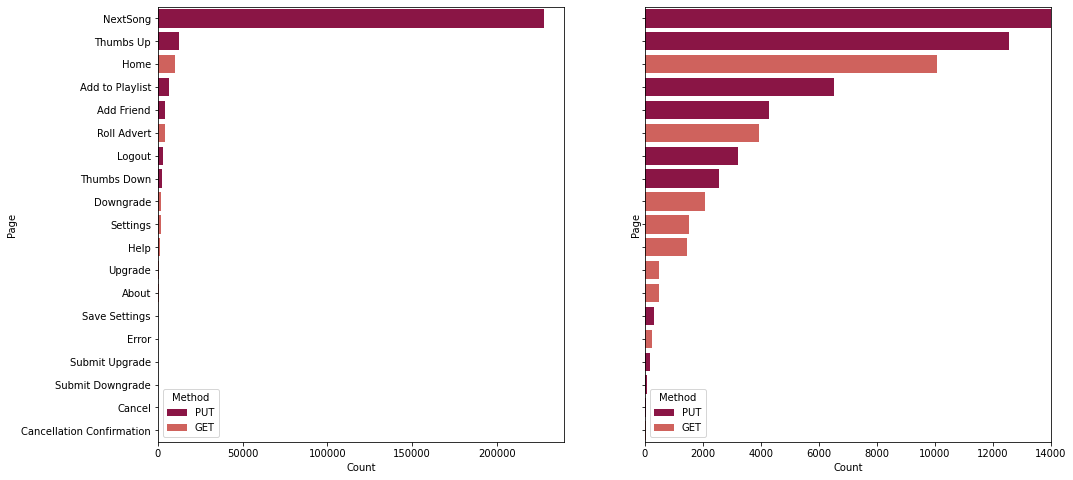

In [46]:
pages_count = df_clean.groupby('page','method').count()

# absolute number of page types
print('There are {} different page types.'.format(pages_count.count()))

# visualization
plot_bar_chart_grouped(df=pages_count, x_col='count', y_col='page', group='method', dodge=False, y_lim=14000)

**Conclusion:** Strikingly, the page type **"NextSong"** makes up for the most events by far. Page types "Cancel" and "Cancellation Confirmation" are the least frequent events. The second subplot shows that PUT methods are connected to the more common page types. Users seem to engage more in **active interactions** like playing the next song, adding to playlist or putting thumbs up/down.

### Browser <a class="anchor" id="browser"></a>

+-----------------+------+-------------------+
|          browser| count|              share|
+-----------------+------+-------------------+
|Internet Explorer| 15347|0.05517447169553557|
|          Firefox| 55646|0.20005464598747458|
|           Safari| 61570|0.22135220057953509|
|           Chrome|145591| 0.5234186817374548|
+-----------------+------+-------------------+



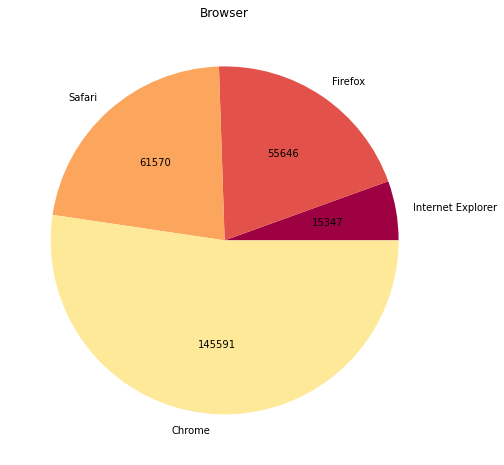

In [47]:
browser = df_clean.groupby('browser').count()

show_share(browser,'count')
    
plot_pie_chart(browser,'count','browser')

**Conclusion:** Chrome makes up for >50% of events, whereas Internet Explorer is the least used browser.

### Device/OS <a class="anchor" id="device-os"></a>

+---------+------+--------------------+
|device_os| count|               share|
+---------+------+--------------------+
|     iPad| 11381| 0.04091618312158013|
|      X11|  8961|0.032215966694708685|
|   iPhone| 11192| 0.04023670340890298|
|Macintosh|102749|   0.369396089935791|
|  Windows|143871|  0.5172350568390173|
+---------+------+--------------------+



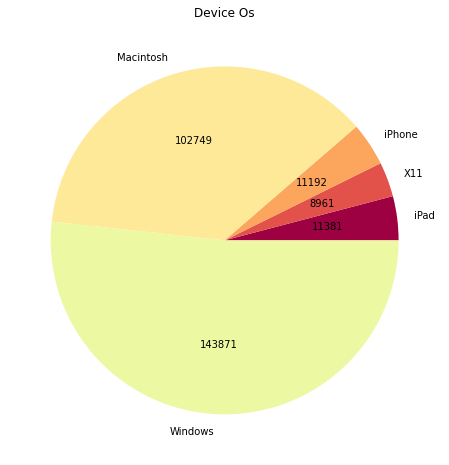

In [48]:
device_os = df_clean.groupby('device_os').count()

show_share(device_os,'count')
    
plot_pie_chart(device_os,'count','device_os')

**Conclusion:** Windows makes up for >50% of events, followed by Macintosh.

### Level <a class="anchor" id="level"></a>

+-----+------+-------------------+
|level| count|              share|
+-----+------+-------------------+
| free| 55721|0.20032428079409248|
| paid|222433| 0.7996757192059075|
+-----+------+-------------------+



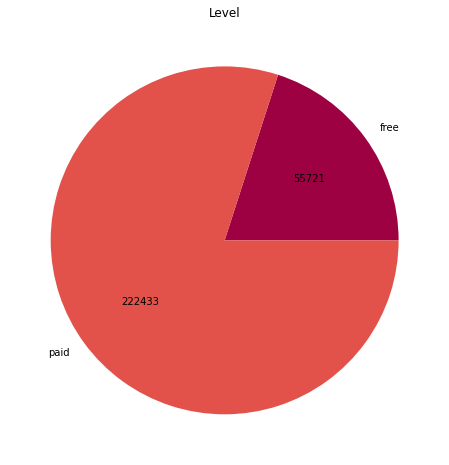

In [49]:
level = df_clean.groupby('level').count()

show_share(level,'count')
    
plot_pie_chart(level,'count','level')

**Conclusion:** About **80% of events** stem from users who are **paying for the service**.

### Gender <a class="anchor" id="gender"></a>

In [50]:
gender_user_combination = df_clean.select('gender','userId').dropDuplicates().count()
unique_users = df_clean.select('userId').dropDuplicates().count()

if gender_user_combination == unique_users:
    print('Each user is associated with a unique gender in the dataset.')
else:
    print('There are {} gender x user combinations more than there are unique users.'.format(gender_user_combination-unique_users))

Each user is associated with a unique gender in the dataset.


+------+-----+------------------+
|gender|count|             share|
+------+-----+------------------+
|     F|  104|0.4622222222222222|
|     M|  121|0.5377777777777778|
+------+-----+------------------+



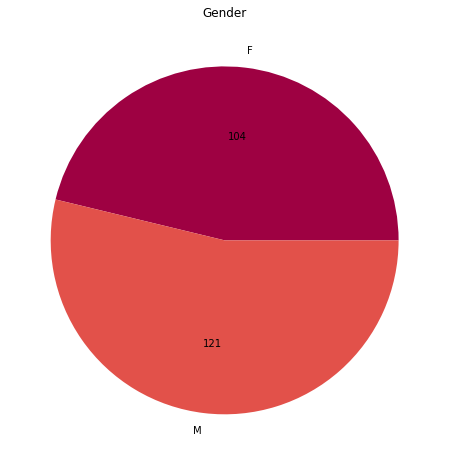

In [51]:
gender = df_clean.select('gender','userId') \
                 .dropDuplicates() \
                 .groupby('gender') \
                 .count()

show_share(gender,'count')

plot_pie_chart(gender,'count','gender')

**Conclusion:** Gender is **nearly balanced** with slightly more males than females.

### State <a class="anchor" id="state"></a>

In [52]:
state_user_combination = df_clean.select('state','userId').dropDuplicates().count()
unique_users = df_clean.select('userId').dropDuplicates().count()

if state_user_combination == unique_users:
    print('Each user is associated with a unique state in the dataset.')
else:
    print('There are {} state x user combinations more than there are unique users.'.format(state_user_combination-unique_users))

Each user is associated with a unique state in the dataset.


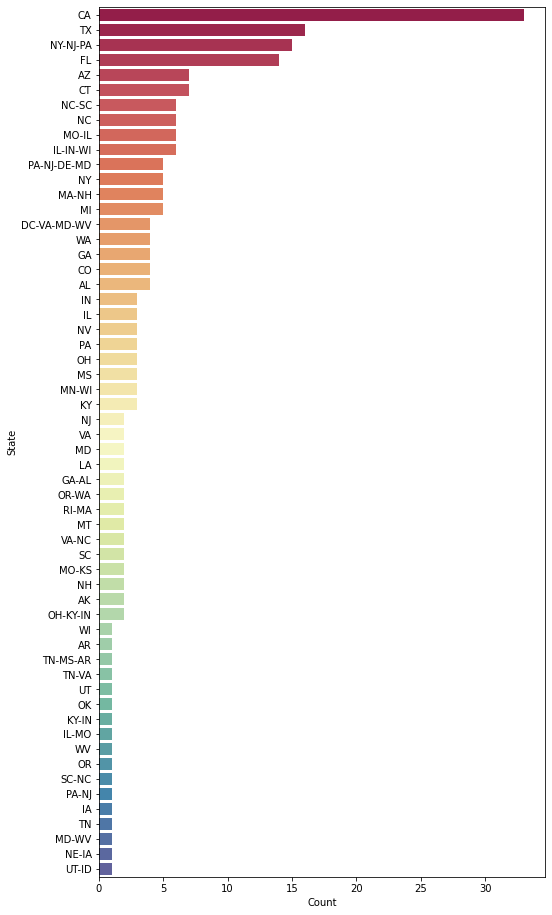

In [53]:
state = df_clean.select('state','userId') \
                 .dropDuplicates() \
                 .groupby('state') \
                 .count()

plot_bar_chart(state,'count','state', size=(8,16), color='Spectral')

**Conclusion:** Users are coming from a **large variety of different states**. California and Texas are the most prominent states (two of the largest states in the US) in the dataset.

### Unique Sessions per User <a class="anchor" id="unique-sessions-per-user"></a>

+-------+------------------------+
|summary|unique_sessions_per_user|
+-------+------------------------+
|  count|                     225|
|   mean|      14.115555555555556|
| stddev|      14.646884657111562|
|    min|                       1|
|    max|                     107|
+-------+------------------------+



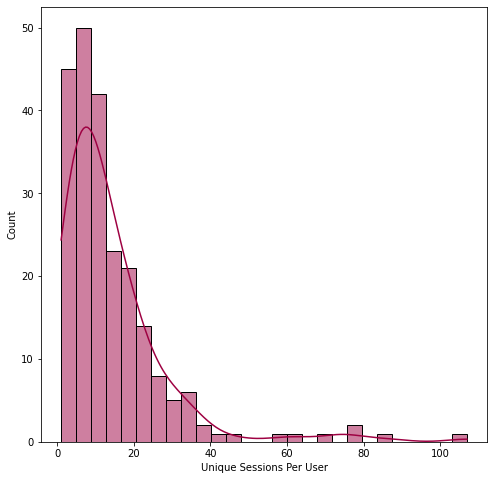

In [54]:
sessions_per_user = df_clean.select('userId','sessionId') \
                            .dropDuplicates() \
                            .groupby('userId') \
                            .count() \
                            .withColumnRenamed('count', 'unique_sessions_per_user')

# descriptives
show_descriptives(sessions_per_user, 'unique_sessions_per_user')
        
# visualization
plot_histogram(sessions_per_user, 'unique_sessions_per_user')

**Conclusion:** Unique sessions over users form a right skewed distribution with an average session count of ~14. The user with the highest count had 107 sessions.

### Items per Session <a class="anchor" id="items-per-session"></a>

+-------+------------------+
|summary| items_per_session|
+-------+------------------+
|  count|              2312|
|   mean| 108.4757785467128|
| stddev|123.76252480420018|
|    min|                 0|
|    max|              1321|
+-------+------------------+



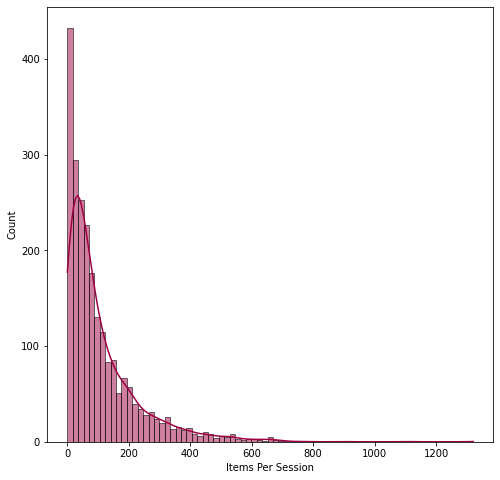

In [55]:
items_per_session = df_clean.groupby('sessionId') \
                            .agg({'itemInSession':'max'}) \
                            .withColumnRenamed('max(itemInSession)', 'items_per_session')

# descriptives
show_descriptives(items_per_session, 'items_per_session')
        
# visualization
plot_histogram(items_per_session, 'items_per_session')

**Conclusion:** Items per session are displayed as a right skewed distribution with an average of ~108 items per session although the majority of sessions consisted of less than 100 items per session. The session with the most items consisted of 1321 items.

### Length per Item or Session <a class="anchor" id="length-per-item-session"></a>

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



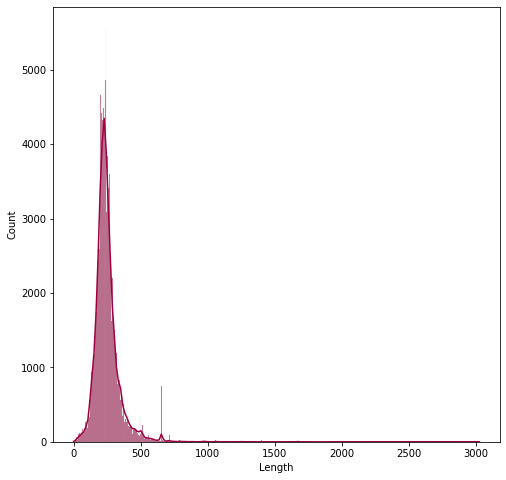

In [57]:
length_per_item = df_clean.filter(f.col('length').isNotNull()).select('length')

# descriptives
show_descriptives(length_per_item, 'length')
        
# visualization
plot_histogram(length_per_item, 'length')

**Conclusion:** The length per item follows a normal distribution with an average length per item of ~249 seconds +/- 99 seconds (standard deviation).

+-------+------------------------+
|summary|total_length_per_session|
+-------+------------------------+
|  count|                    2253|
|   mean|      25222.202461873054|
| stddev|      28117.169683359738|
|    min|               153.46893|
|    max|       267758.1329100001|
+-------+------------------------+



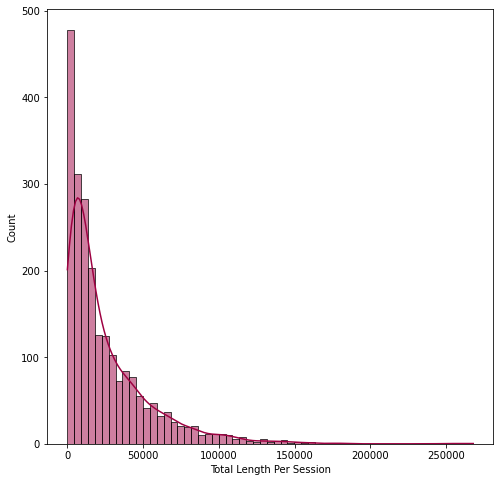

In [58]:
length_per_session = df_clean.filter(f.col('length').isNotNull()) \
                             .groupby('sessionId') \
                             .agg({'length':'sum'}) \
                             .withColumnRenamed('sum(length)', 'total_length_per_session')

# descriptives
show_descriptives(length_per_session, 'total_length_per_session')
        
# visualization
plot_histogram(length_per_session, 'total_length_per_session')

**Conclusion:** The total length per session stems from a right skewed distribution with an average length per session of ~25222 seconds although the majority of sessions have a total length shorter than 25000 seconds.

### Days Since Registration <a class="anchor" id="days-since-registration"></a>

+-------+-----------------------+
|summary|days_since_registration|
+-------+-----------------------+
|  count|                    225|
|   mean|      79.81777777777778|
| stddev|      37.62535766849984|
|    min|                      0|
|    max|                    256|
+-------+-----------------------+



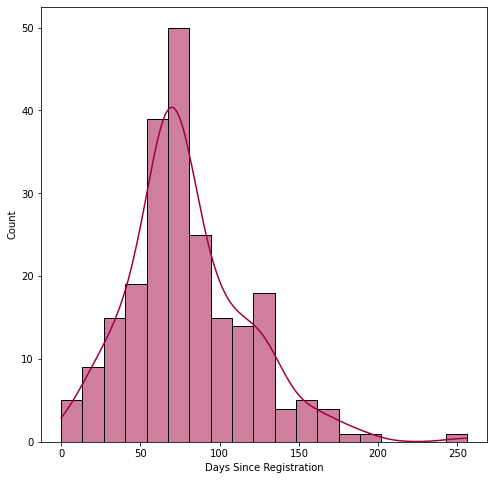

In [59]:
days_since_registration_per_user = df_clean.select('userId','days_since_registration') \
                            .groupby('userId') \
                            .agg({'days_since_registration':'max'}) \
                            .withColumnRenamed('max(days_since_registration)', 'days_since_registration')

# descriptives
show_descriptives(days_since_registration_per_user, 'days_since_registration')
        
# visualization
plot_histogram(days_since_registration_per_user, 'days_since_registration')

**Conclusion:** The days since registration is nearly normally distributed over events with a mean of ~80 days +/- 38 days (standard deviation).

### Seasonality <a class="anchor" id="seasonality"></a>

In [60]:
df_clean.groupby('date').count().sort('date').collect()

[Row(date='2018-10-01', count=4286),
 Row(date='2018-10-02', count=4453),
 Row(date='2018-10-03', count=3966),
 Row(date='2018-10-04', count=4645),
 Row(date='2018-10-05', count=4485),
 Row(date='2018-10-06', count=3711),
 Row(date='2018-10-07', count=2937),
 Row(date='2018-10-08', count=5137),
 Row(date='2018-10-09', count=5474),
 Row(date='2018-10-10', count=6178),
 Row(date='2018-10-11', count=5623),
 Row(date='2018-10-12', count=5398),
 Row(date='2018-10-13', count=2975),
 Row(date='2018-10-14', count=2629),
 Row(date='2018-10-15', count=5153),
 Row(date='2018-10-16', count=5802),
 Row(date='2018-10-17', count=5235),
 Row(date='2018-10-18', count=5370),
 Row(date='2018-10-19', count=5545),
 Row(date='2018-10-20', count=5697),
 Row(date='2018-10-21', count=3036),
 Row(date='2018-10-22', count=4888),
 Row(date='2018-10-23', count=4300),
 Row(date='2018-10-24', count=5667),
 Row(date='2018-10-25', count=4993),
 Row(date='2018-10-26', count=4296),
 Row(date='2018-10-27', count=3500),
 

**Conclusion:** Seasonality cannot be properly investigated on the small dataset since it includes 2 full months only. **For the following exploratory time series analyses, this should be taken into account as well.**

### Time Series of Page Types <a class="anchor" id="time-series-page-types"></a>

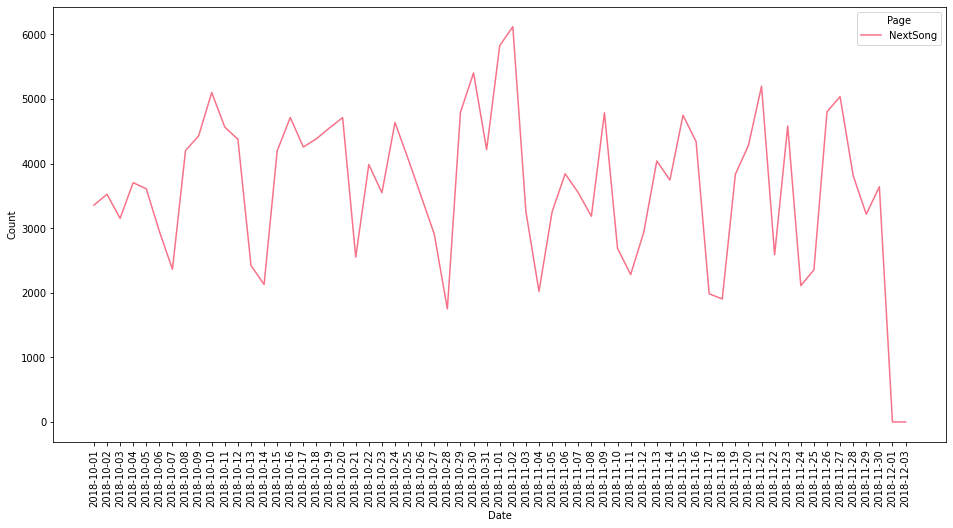

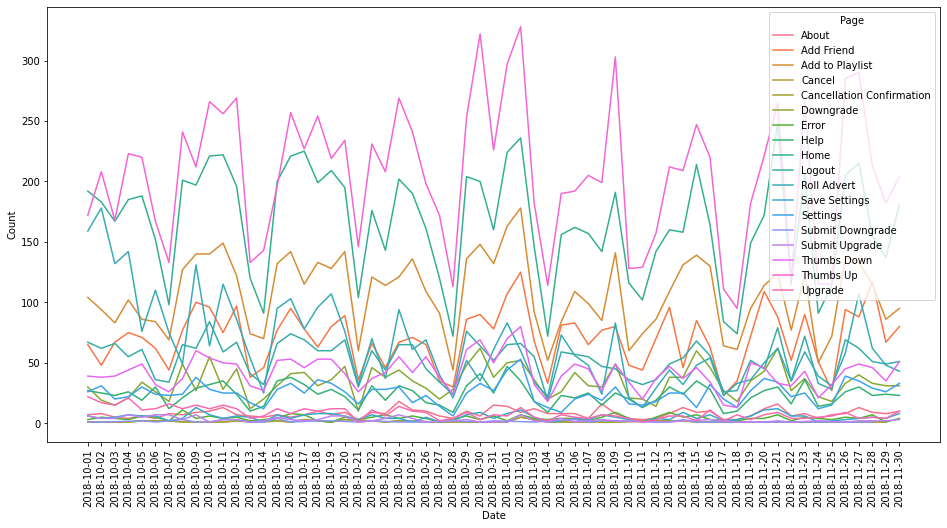

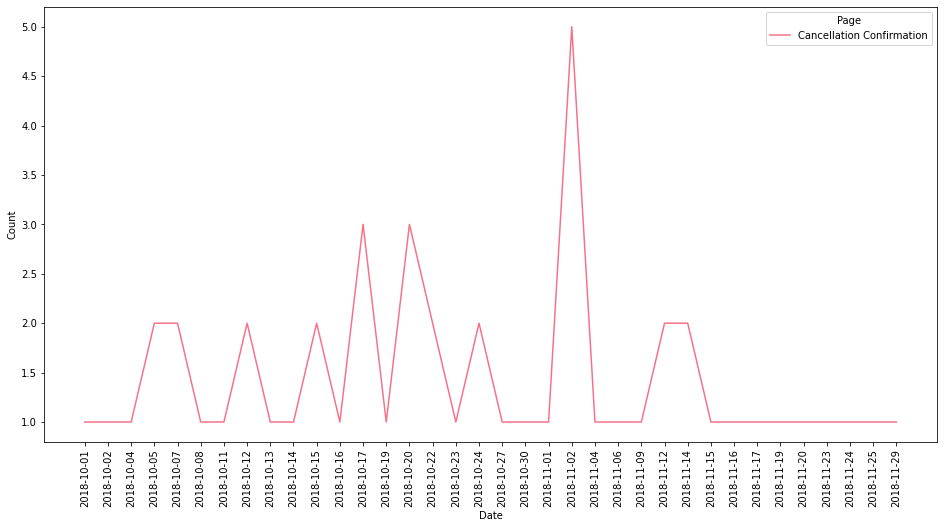

In [62]:
# plot page type 'NextSong' only
events_per_day = df_clean.filter(f.col('page')=='NextSong').groupby('date','page').count().sort('date','page')

plot_line_chart(events_per_day, 'date', 'count', 'page')

#plot all page types except 'NextSong'
events_per_day = df_clean.filter(f.col('page')!='NextSong').groupby('date','page').count().sort('date','page')

plot_line_chart(events_per_day, 'date', 'count', 'page')

#plot page type 'Cancellation Confirmation'
events_per_day = df_clean.filter(f.col('page')=='Cancellation Confirmation').groupby('date','page').count().sort('date','page')

plot_line_chart(events_per_day, 'date', 'count', 'page')

**Conclusion:** The time series plots are separated for page types "NextSong" (most frequent page type, large absolute difference in event count), all except "NextSong" and "Cancellation Confirmation" (focus on relevant page type for user churn) for better visualization.

All time series plots on the date level show a similar "bumpy" course in events which can be explained by **less activity during the weekend as further investigated below**. The page type "Cancellation Confirmation" shows a different pattern. It must be noted that this page type is the rarest page type in terms of events. It can be seen that the most cancelation events happened on the 2018-11-02 with an event count of 5.

### Weekday Time Series of Page Types <a class="anchor" id="weekday-time-series-page-types"></a>

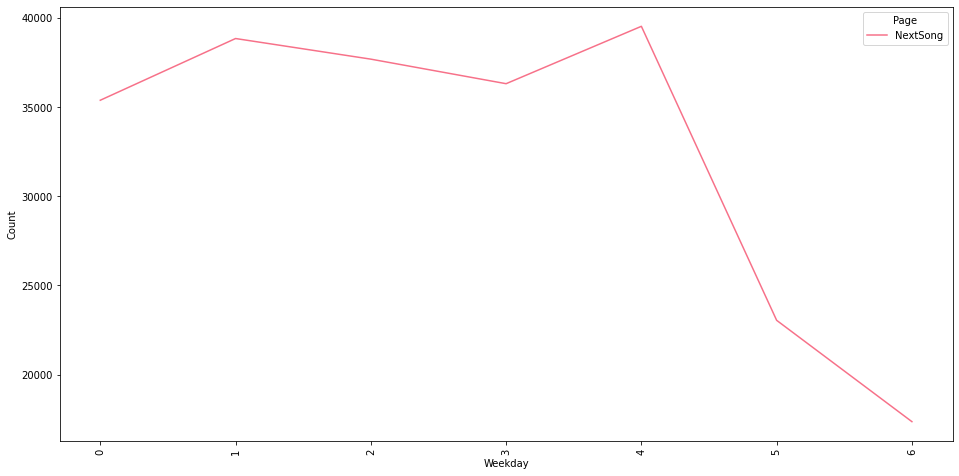

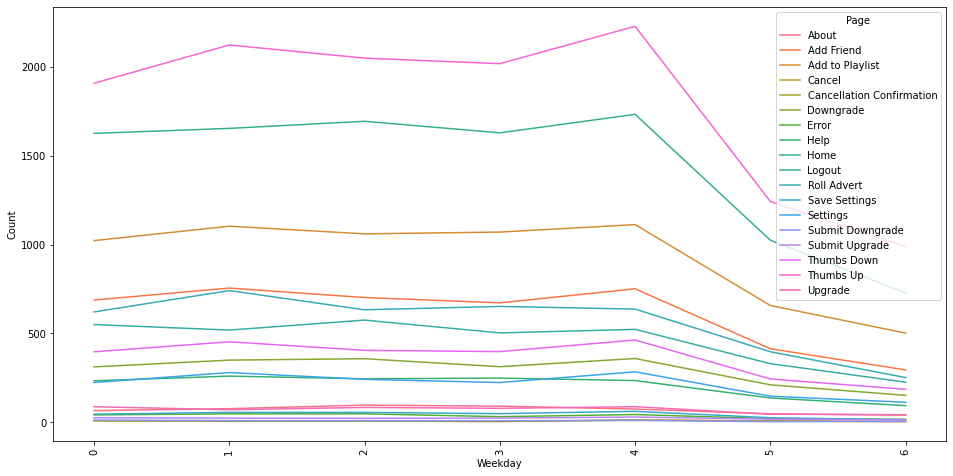

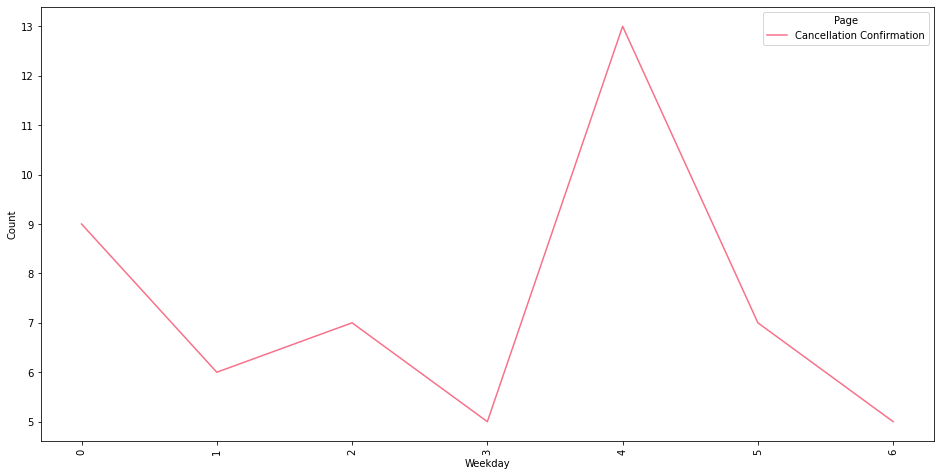

In [63]:
# plot page type 'NextSong' only
events_per_weekday = df_clean.filter(f.col('page')=='NextSong').groupby('weekday','page').count().sort('weekday','page')

plot_line_chart(events_per_weekday, 'weekday', 'count', 'page')

#plot all page types except 'NextSong'
events_per_weekday = df_clean.filter(f.col('page')!='NextSong').groupby('weekday','page').count().sort('weekday','page')

plot_line_chart(events_per_weekday, 'weekday', 'count', 'page')

#plot page type 'Cancellation Confirmation'
events_per_weekday = df_clean.filter(f.col('page')=='Cancellation Confirmation').groupby('weekday','page').count().sort('weekday','page')

plot_line_chart(events_per_weekday, 'weekday', 'count', 'page')

**Conclusion:** The weekday time series shows pretty consistent activity during the weekdays 0-4 (Monday to Friday) and a **striking drop of activity on the weekend**. The rarer the page type, the less steep the drop. For "Cancellation Confirmation", this dataset shows an increase on Fridays. Again, the overall low event count for this page type should be noted (y-axis).

### Hourly Time Series of Page Types <a class="anchor" id="hourly-time-series-page-types"></a>

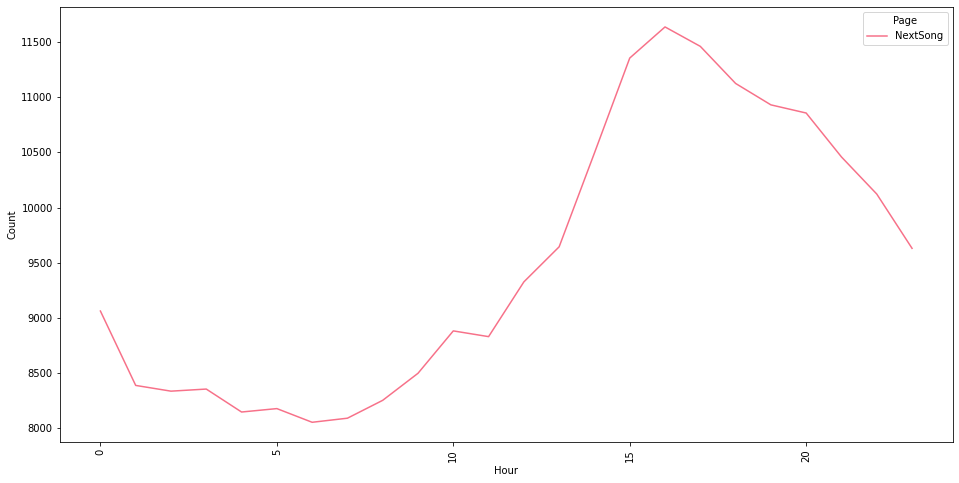

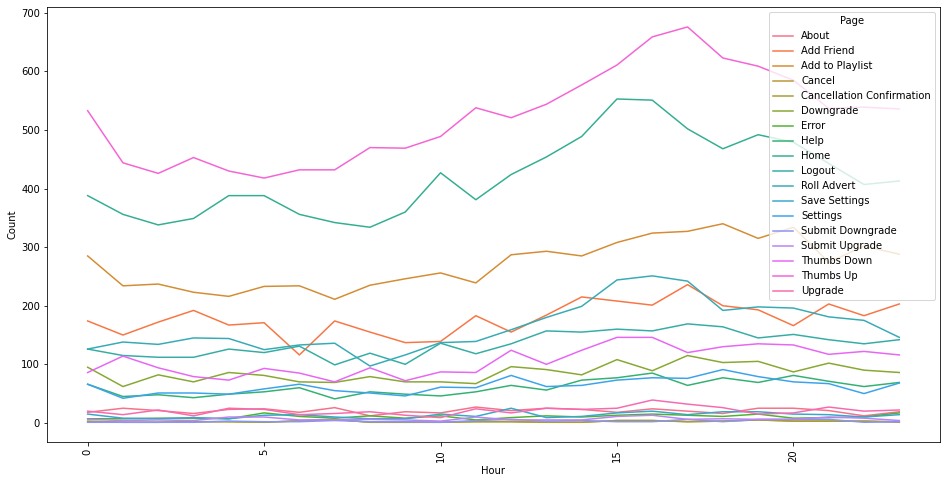

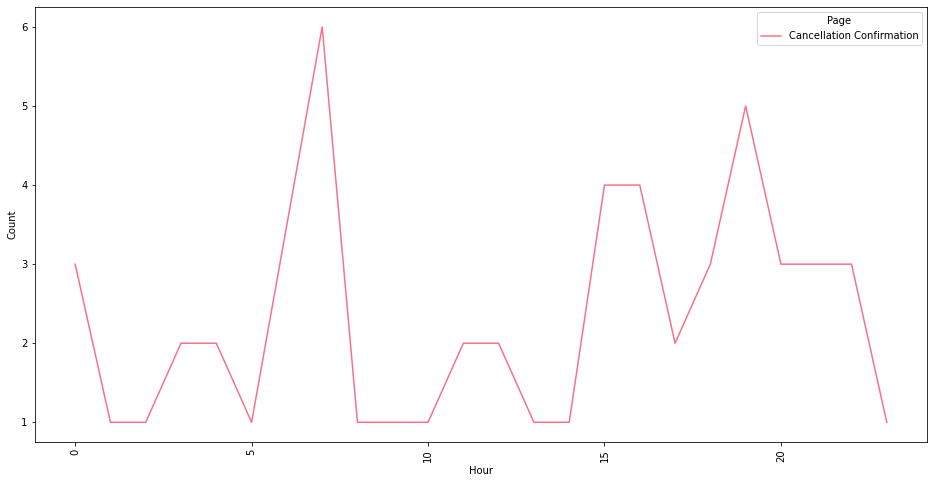

In [64]:
# plot page type 'NextSong' only
events_per_hour = df_clean.filter(f.col('page')=='NextSong').groupby('hour','page').count().sort('hour','page')

plot_line_chart(events_per_hour, 'hour', 'count', 'page')

#plot all page types except 'NextSong'
events_per_hour = df_clean.filter(f.col('page')!='NextSong').groupby('hour','page').count().sort('hour','page')

plot_line_chart(events_per_hour, 'hour', 'count', 'page')

#plot page type 'Cancellation Confirmation'
events_per_hour = df_clean.filter(f.col('page')=='Cancellation Confirmation').groupby('hour','page').count().sort('hour','page')

plot_line_chart(events_per_hour, 'hour', 'count', 'page')

**Conclusion:** The hourly time series reveals the **most intense audio playback (page type "NextSong") to happen in the afternoon/evening from 3pm to 8pm**. As expected the **activity is lowest at night and in the early morning**. Overall, the rarer the page type, the less prominent this pattern. "Cancellation Confirmation" seems to happen without a clear pattern. Contrary to the previous observation, a peak is reached in the early morning arount 6-7 am. Again, the overall low event count for this page type should be notes (y-axis) which makes a potential pattern hard to interpret and not reliable.

### Time Series of Registration <a class="anchor" id="time-series-registration"></a>

In [65]:
registration_user_combination = df_clean.select('registration_datetime','userId').dropDuplicates().count()
unique_users = df_clean.select('userId').dropDuplicates().count()

if registration_user_combination == unique_users:
    print('Each user is associated with a unique registration datetime in the dataset.')
else:
    print('There are {} registration datetime x user combinations more than there are unique users.'.format(registration_user_combination-unique_users))

Each user is associated with a unique registration datetime in the dataset.


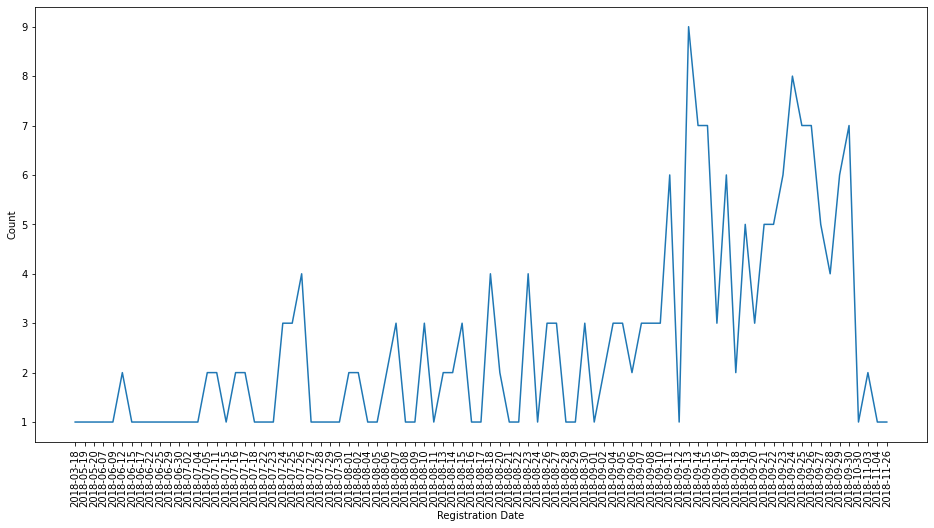

In [66]:
users_per_registration_day = df_clean.select('userId','registration_date') \
                                     .dropDuplicates() \
                                     .groupby('registration_date') \
                                     .count() \
                                     .sort('registration_date')

plot_line_chart(users_per_registration_day, 'registration_date', 'count', legend=None)

**Conclusion:** The dataset contains more users with recent registration dates in comparison to the event timestamps, suggesting that **users are more active shortly after registration for the service**. This could also show **general growth** of the **business acquiring new customers over time**.

### Weekday Time Series of Registration <a class="anchor" id="weekday-time-series-registration"></a>

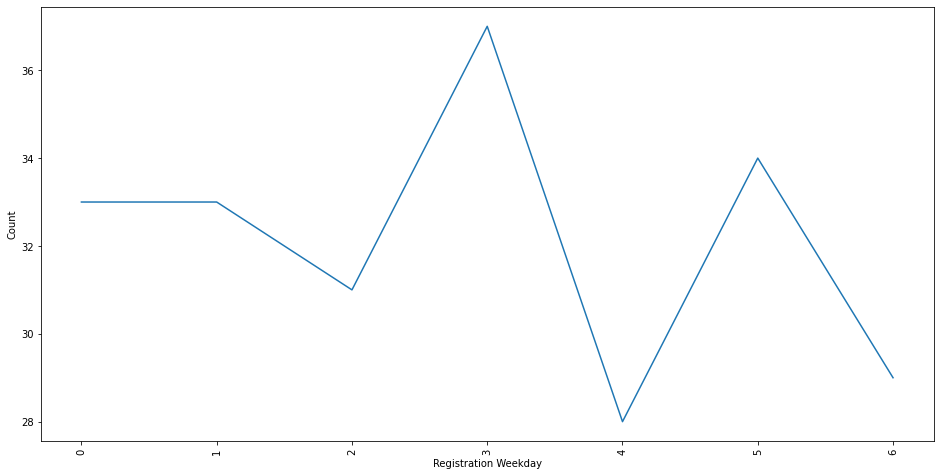

In [67]:
users_per_registration_weekday = df_clean.select('userId','registration_weekday') \
                                     .dropDuplicates() \
                                     .groupby('registration_weekday') \
                                     .count() \
                                     .sort('registration_weekday')

plot_line_chart(users_per_registration_weekday, 'registration_weekday', 'count', legend=None)

**Conclusion:** Registration based on weekday seems to be irregular with peaks on Thursdays and Saturdays within the weekend. These differences are not large as can be seen from the total counts (y axis).

### Hourly Time Series of Registration <a class="anchor" id="hourly-time-series-registration"></a>

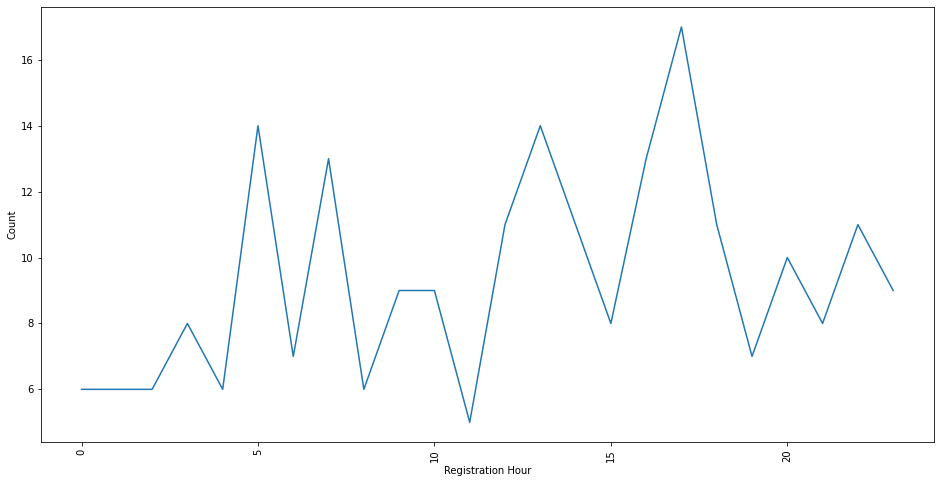

In [68]:
users_per_registration_hour = df_clean.select('userId','registration_hour') \
                                      .dropDuplicates() \
                                      .groupby('registration_hour') \
                                      .count() \
                                      .sort('registration_hour')

plot_line_chart(users_per_registration_hour, 'registration_hour', 'count', legend=None)

**Conclusion:** The most **popular hours for registration** seem to be focused around the afternoon **12pm - 17pm**.

### LABEL | Churn Definition <a class="anchor" id="churn-definition"></a>

A column `churn` is created to use as the label for a user churn prediction model. All events with page = `Cancellation Confirmation` will be regarded as **churn events** regardless of free or paid subscription.

In [69]:
# churn events & users
df_clean.filter(f.col('page')=='Cancellation Confirmation') \
        .groupby('page','level') \
        .count() \
        .sort('page','level') \
        .withColumnRenamed('count','event_count') \
        .show() 

df_clean.filter(f.col('page')=='Cancellation Confirmation').select('page','level','userId') \
                 .dropDuplicates() \
                 .groupby('page','level') \
                 .count() \
                 .withColumnRenamed('count','user_count') \
                 .show()

+--------------------+-----+-----------+
|                page|level|event_count|
+--------------------+-----+-----------+
|Cancellation Conf...| free|         21|
|Cancellation Conf...| paid|         31|
+--------------------+-----+-----------+

+--------------------+-----+----------+
|                page|level|user_count|
+--------------------+-----+----------+
|Cancellation Conf...| free|        21|
|Cancellation Conf...| paid|        31|
+--------------------+-----+----------+



**Conclusion:** User and event count are the same, showing that a user only cancels once. This is a sign for high data consistency. Overall, 52 users churned.

In [70]:
# prepare function to mark users according to page types

def mark_users(df, page_type, new_col_name, user_col):
    '''
    '''
    # user defined function to find 'Cancellation Confirmation' events
    mark_events = f.udf(lambda x : 1 if x==page_type else 0, IntegerType())

    # create new column by applying mark_events to column 'page' - EVENT LEVEL
    df_events = df.withColumn(new_col_name, mark_events(df['page']))

    # modify new column by applying a window function - USER LEVEL
    users_window = Window.partitionBy(user_col).rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    df_users = df_events.withColumn(new_col_name, f.max(new_col_name).over(users_window))
    
    return df_users

In [72]:
df_clean = mark_users(df_clean, 'Cancellation Confirmation', 'churn', 'userId')

churn_list = []
for idx in df_clean.select('userId','churn') \
                   .dropDuplicates() \
                   .groupby('churn') \
                   .count() \
                   .sort('churn') \
                   .collect():
    churn_list.append(idx['count'])
    

print('{} % user churn.\n'.format('{:.0f}'.format(churn_list[1] / sum(churn_list) * 100)))

print('Example of a churn user:')
df_clean.filter(f.col('userId')=='125').select('userId','datetime','page','churn').show()

print('Example of a non-churn user:')
df_clean.filter(f.col('userId')=='156').select('userId','datetime','page','churn').show()

23 % user churn.

Example of a churn user:
+------+-------------------+--------------------+-----+
|userId|           datetime|                page|churn|
+------+-------------------+--------------------+-----+
|   125|2018-10-12 04:05:44|            NextSong|    1|
|   125|2018-10-12 04:11:21|            NextSong|    1|
|   125|2018-10-12 04:15:11|            NextSong|    1|
|   125|2018-10-12 04:18:34|            NextSong|    1|
|   125|2018-10-12 04:22:04|            NextSong|    1|
|   125|2018-10-12 04:28:35|            NextSong|    1|
|   125|2018-10-12 04:32:08|            NextSong|    1|
|   125|2018-10-12 04:35:06|            NextSong|    1|
|   125|2018-10-12 04:35:17|         Roll Advert|    1|
|   125|2018-10-12 04:35:18|              Cancel|    1|
|   125|2018-10-12 04:35:18|Cancellation Conf...|    1|
+------+-------------------+--------------------+-----+

Example of a non-churn user:
+------+-------------------+-----------+-----+
|userId|           datetime|       page|

### Pages <a class="anchor" id="pages"></a>

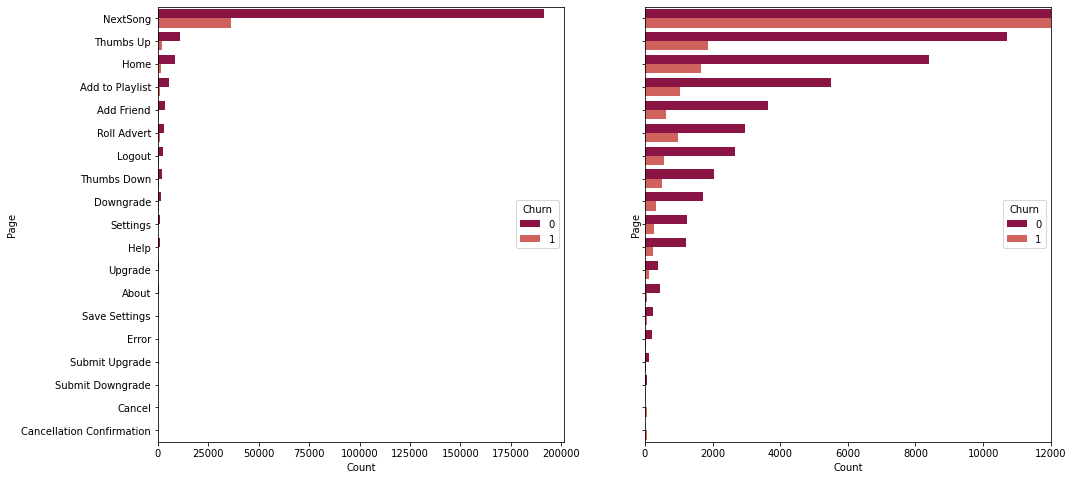

In [73]:
for i in ['churn']:
    pages_count = df_clean.groupby('page',i).count()

    # visualization
    plot_bar_chart_grouped(df=pages_count,x_col='count',y_col='page',group=i, y_lim=12000)

**Conclusion:** From the visualizations, it appears that the share of churn users is more or less similar over different page types. **On a very detailed view, "Roll Advert" could be a slightly repellent feature of the service.**

### Browser <a class="anchor" id="browser-2"></a>

+-------+-----+------+-------------------+
|browser|churn| count|              share|
+-------+-----+------+-------------------+
| Chrome|    0|125030| 0.8587756111298088|
| Chrome|    1| 20561|0.14122438887019115|
+-------+-----+------+-------------------+

+-------+-----+-----+-------------------+
|browser|churn|count|              share|
+-------+-----+-----+-------------------+
| Safari|    0|53895| 0.8753451356179958|
| Safari|    1| 7675|0.12465486438200422|
+-------+-----+-----+-------------------+

+-------+-----+-----+------------------+
|browser|churn|count|             share|
+-------+-----+-----+------------------+
|Firefox|    0|40799|0.7331883693347231|
|Firefox|    1|14847|0.2668116306652769|
+-------+-----+-----+------------------+

+-----------------+-----+-----+-------------------+
|          browser|churn|count|              share|
+-----------------+-----+-----+-------------------+
|Internet Explorer|    0|13566|  0.883951260832736|
|Internet Explorer|    1| 1781|0.

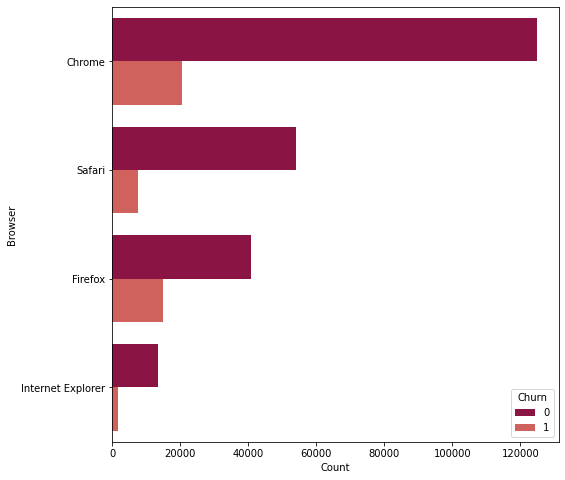

In [74]:
for i in ['churn']:
    browser_count = df_clean.groupby('browser',i).count()
    
    show_share(browser_count.filter(f.col('browser')=='Chrome').sort('churn'),'count')
    show_share(browser_count.filter(f.col('browser')=='Safari').sort('churn'),'count')
    show_share(browser_count.filter(f.col('browser')=='Firefox').sort('churn'),'count')
    show_share(browser_count.filter(f.col('browser')=='Internet Explorer').sort('churn'),'count')

    # visualization
    plot_bar_chart_grouped(df=browser_count,x_col='count',y_col='browser',group=i, subplots=1, size=(8,8))

**Conclusion:** The **share of churn users per browser is largest for Firefox (~27%)**. It is interesting to look at technical characteristics in this context, since this could **hint towards a technical problem with the service**. Maybe Firefox prevents it from working exactly as expected and more problems occur during a user journey resulting in a higher share of users retracting from the service.

### Device/OS <a class="anchor" id="device-os-2"></a>

+---------+-----+------+-------------------+
|device_os|churn| count|              share|
+---------+-----+------+-------------------+
|  Windows|    0|119134| 0.8280612493136212|
|  Windows|    1| 24737|0.17193875068637876|
+---------+-----+------+-------------------+

+---------+-----+-----+-------------------+
|device_os|churn|count|              share|
+---------+-----+-----+-------------------+
|Macintosh|    0|85394| 0.8310932466496024|
|Macintosh|    1|17355|0.16890675335039756|
+---------+-----+-----+-------------------+

+---------+-----+-----+-----+
|device_os|churn|count|share|
+---------+-----+-----+-----+
|     iPad|    0|11381|  1.0|
+---------+-----+-----+-----+

+---------+-----+-----+-------------------+
|device_os|churn|count|              share|
+---------+-----+-----+-------------------+
|   iPhone|    0|10182| 0.9097569692637598|
|   iPhone|    1| 1010|0.09024303073624017|
+---------+-----+-----+-------------------+

+---------+-----+-----+-------------------+
|dev

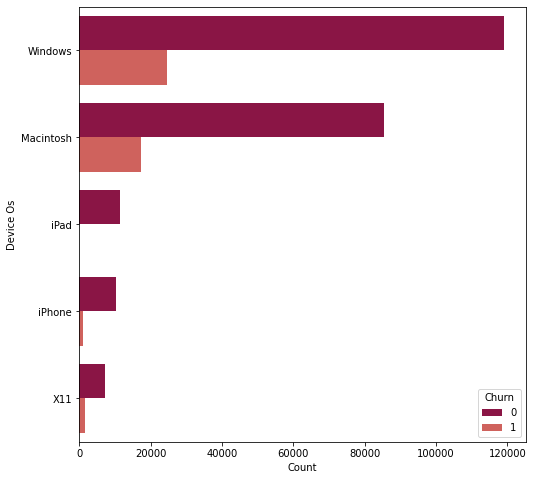

In [75]:
for i in ['churn']:
    device_os_count = df_clean.groupby('device_os',i).count()
    
    show_share(device_os_count.filter(f.col('device_os')=='Windows').sort('churn'),'count')
    show_share(device_os_count.filter(f.col('device_os')=='Macintosh').sort('churn'),'count')
    show_share(device_os_count.filter(f.col('device_os')=='iPad').sort('churn'),'count')
    show_share(device_os_count.filter(f.col('device_os')=='iPhone').sort('churn'),'count')
    show_share(device_os_count.filter(f.col('device_os')=='X11').sort('churn'),'count')

    # visualization
    plot_bar_chart_grouped(df=device_os_count,x_col='count',y_col='device_os',group=i, subplots=1, size=(8,8))

**Conclusion:** From the visualizations, it appears that the share of churn users is **slightly lower for iPad (no churn at all) and iPhone (~9%).**

### Level <a class="anchor" id="level-2"></a>

+-----+-----+-----+-------------------+
|level|churn|count|              share|
+-----+-----+-----+-------------------+
| free|    0|43333| 0.7776780746935625|
| free|    1|12388|0.22232192530643743|
+-----+-----+-----+-------------------+

+-----+-----+------+-------------------+
|level|churn| count|              share|
+-----+-----+------+-------------------+
| paid|    0|189957| 0.8539964843346086|
| paid|    1| 32476|0.14600351566539138|
+-----+-----+------+-------------------+



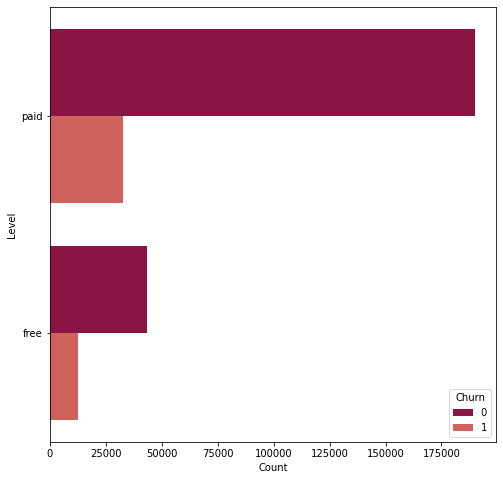

In [76]:
for i in ['churn']:
    level_count = df_clean.groupby('level',i).count()
    
    show_share(level_count.filter(f.col('level')=='free').sort('churn'),'count')
    show_share(level_count.filter(f.col('level')=='paid').sort('churn'),'count')

    # visualization
    plot_bar_chart_grouped(df=level_count,x_col='count',y_col='level', group=i, subplots=1, size=(8,8))

**Conclusion:** **Slightly more users churn from the free service** rather than the paid service. Thus, once a user is converted to a paying user, he or she might be slightly less likely to churn.

### Gender <a class="anchor" id="gender-2"></a>

+------+-----+------+-------------------+
|gender|churn| count|              share|
+------+-----+------+-------------------+
|     F|    0|135410| 0.8759978780939073|
|     F|    1| 19168|0.12400212190609272|
+------+-----+------+-------------------+

+------+-----+-----+-------------------+
|gender|churn|count|              share|
+------+-----+-----+-------------------+
|     M|    0|97880| 0.7920631837897326|
|     M|    1|25696|0.20793681621026736|
+------+-----+-----+-------------------+



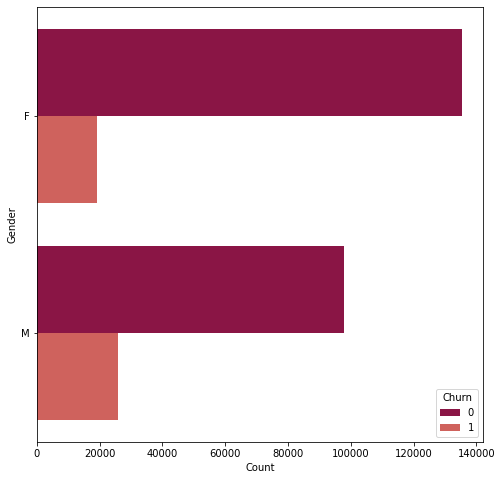

In [77]:
for i in ['churn']:
    gender_count = df_clean.groupby('gender',i).count()
    
    show_share(gender_count.filter(f.col('gender')=='F').sort('churn'),'count')
    show_share(gender_count.filter(f.col('gender')=='M').sort('churn'),'count')

    # visualization
    plot_bar_chart_grouped(df=gender_count,x_col='count',y_col='gender',group=i, subplots=1, size=(8,8))

**Conclusion:** The share of churn users is **slightly higher for males** than for females.

### State <a class="anchor" id="state-2"></a>

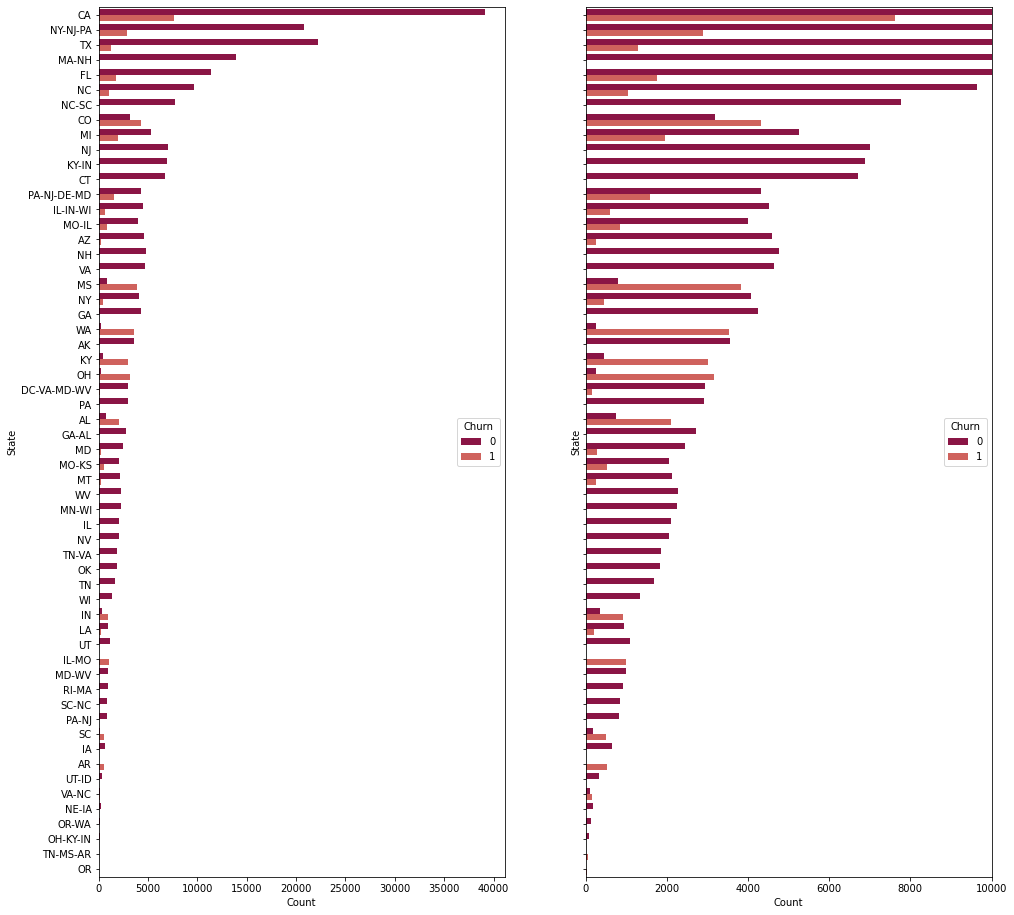

In [78]:
for i in ['churn']:
    state_count = df_clean.groupby('state',i).count()

    # visualization
    plot_bar_chart_grouped(df=state_count,x_col='count',y_col='state',group=i, size=(16,16), y_lim=10000)

**Conclusion:** There are states with more churn users than non-churn users. These are all states with smaller event counts. Overall, the visualization draws a complex picture of churn/non-churn based on state. In order to not make the machine learning classification models too complex and avoid overfitting on the training data which is a very small subset of the actually available data in this case, state will not be included as feature in the models later on. This should help generalizing better to new test data.

### Unique Sessions per User <a class="anchor" id="unique-sessions-per-user-2"></a>

Non-churn:

+-------+------------------------+
|summary|unique_sessions_per_user|
+-------+------------------------+
|  count|                     173|
|   mean|      15.254335260115607|
| stddev|      15.866963127421307|
|    min|                       1|
|    max|                     107|
+-------+------------------------+

Churn:

+-------+------------------------+
|summary|unique_sessions_per_user|
+-------+------------------------+
|  count|                      52|
|   mean|      10.326923076923077|
| stddev|        8.61080295917924|
|    min|                       1|
|    max|                      37|
+-------+------------------------+



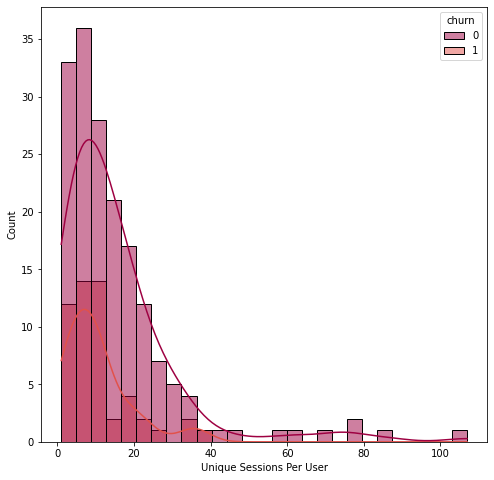

In [79]:
for i in ['churn']:
    sessions_per_user = df_clean.select('userId',i,'sessionId') \
                                .dropDuplicates() \
                                .groupby('userId',i) \
                                .count() \
                                .withColumnRenamed('count', 'unique_sessions_per_user')
    # descriptives
    print('Non-churn:\n')
    show_descriptives(sessions_per_user.filter(f.col(i)==0), 'unique_sessions_per_user')
    print('Churn:\n')
    show_descriptives(sessions_per_user.filter(f.col(i)==1), 'unique_sessions_per_user')

    # visualization
    plot_histogram_grouped(sessions_per_user, 'unique_sessions_per_user', i, 2)

**Conclusion:** Unique sessions per user follow a right skewed distribution for churn and non-churn users. On average, **churn users have a lower session count (about 10 +/- 9 standard deviation) in comparison to non-churn users (about 15 +/- 16 standard deviation)**.

### Items per Session <a class="anchor" id="items-per-session-2"></a>

Non-churn:

+-------+------------------+
|summary| items_per_session|
+-------+------------------+
|  count|              2110|
|   mean|103.67298578199052|
| stddev|121.35638193679698|
|    min|                 0|
|    max|              1321|
+-------+------------------+

Churn:

+-------+------------------+
|summary| items_per_session|
+-------+------------------+
|  count|               468|
|   mean| 93.56837606837607|
| stddev|111.28722038836416|
|    min|                 0|
|    max|               889|
+-------+------------------+



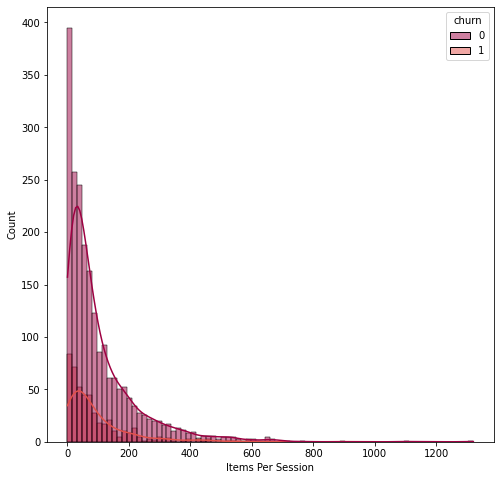

In [80]:
for i in ['churn']:
    items_per_session = df_clean.groupby('sessionId',i) \
                            .agg({'itemInSession':'max'}) \
                            .withColumnRenamed('max(itemInSession)', 'items_per_session')
    
    # descriptives
    print('Non-churn:\n')
    show_descriptives(items_per_session.filter(f.col(i)==0), 'items_per_session')
    print('Churn:\n')
    show_descriptives(items_per_session.filter(f.col(i)==1), 'items_per_session')

    # visualization
    plot_histogram_grouped(items_per_session, 'items_per_session', i, 2)

**Conclusion:** The items per session follow a right skewed distribution for churn and non-churn users. There is a marginal difference on average with ~94 items per session for churn users in comparison to ~104 items per session for non-churn users, although the majority of sessions consisted of less than 90 items per session for both groups.

### Length per Item or Session <a class="anchor" id="length-per-item-session-2"></a>

Non-churn:

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            191714|
|   mean|249.20913538880816|
| stddev|  98.6258830014688|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+

Churn:

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|             36394|
|   mean|248.63279564406218|
| stddev|102.38497717575477|
|    min|           4.04853|
|    max|        3024.66567|
+-------+------------------+



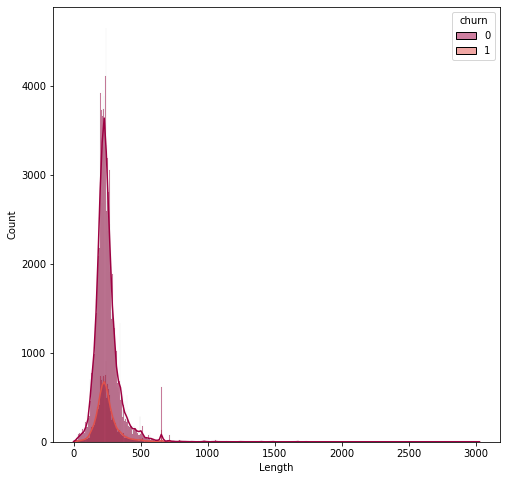

In [82]:
for i in ['churn']:
    length_per_item = df_clean.filter(f.col('length').isNotNull()).select('length',i)
    
    # descriptives
    print('Non-churn:\n')
    show_descriptives(length_per_item.filter(f.col(i)==0), 'length')
    print('Churn:\n')
    show_descriptives(length_per_item.filter(f.col(i)==1), 'length')

    # visualization
    plot_histogram_grouped(length_per_item, 'length', i, 2)

**Conclusion:** The length per item is very similar for churn and non-churn users.

Non-churn:

+-------+------------------------+
|summary|total_length_per_session|
+-------+------------------------+
|  count|                    2054|
|   mean|         23260.409046704|
| stddev|      26686.159846696526|
|    min|               153.46893|
|    max|       267758.1329100001|
+-------+------------------------+

Churn:

+-------+------------------------+
|summary|total_length_per_session|
+-------+------------------------+
|  count|                     456|
|   mean|      19843.732378662284|
| stddev|      23277.973173940158|
|    min|                45.63546|
|    max|      176615.41127000016|
+-------+------------------------+



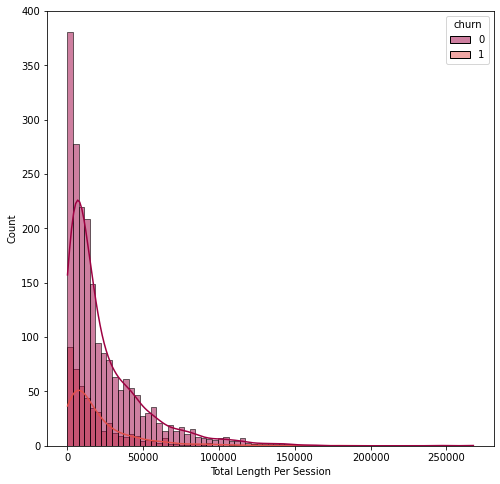

In [83]:
for i in ['churn']:
    length_per_session = df_clean.filter(f.col('length').isNotNull()) \
                             .groupby('sessionId',i) \
                             .agg({'length':'sum'}) \
                             .withColumnRenamed('sum(length)', 'total_length_per_session')
    # descriptives
    print('Non-churn:\n')
    show_descriptives(length_per_session.filter(f.col(i)==0), 'total_length_per_session')
    print('Churn:\n')
    show_descriptives(length_per_session.filter(f.col(i)==1), 'total_length_per_session')

    # visualization
    plot_histogram_grouped(length_per_session, 'total_length_per_session', i, 2)

**Conclusion:** The total length per session follows a right skewed distribution for churn and non-churn users. There is a marginal difference on average with ~19843 seconds per session for churn users in comparison to ~23260 seconds per session for non-churn users, although the majority of sessions consisted of less than 19800 seconds length for both groups.

### Days Since Registration <a class="anchor" id="days-since-registration-2"></a>

Non-churn:

+-------+-----------------------+
|summary|days_since_registration|
+-------+-----------------------+
|  count|                    173|
|   mean|      86.56647398843931|
| stddev|      35.33432397636966|
|    min|                      0|
|    max|                    256|
+-------+-----------------------+

Churn:

+-------+-----------------------+
|summary|days_since_registration|
+-------+-----------------------+
|  count|                     52|
|   mean|      57.36538461538461|
| stddev|     36.587809416366895|
|    min|                      5|
|    max|                    188|
+-------+-----------------------+



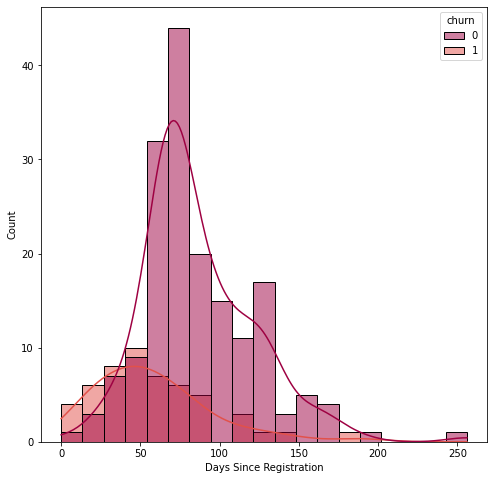

In [84]:
for i in ['churn']:
    days_since_registration_per_user = df_clean.select('userId','days_since_registration',i) \
                            .groupby('userId',i) \
                            .agg({'days_since_registration':'max'}) \
                            .withColumnRenamed('max(days_since_registration)', 'days_since_registration')
    
    # descriptives
    print('Non-churn:\n')
    show_descriptives(days_since_registration_per_user.filter(f.col(i)==0), 'days_since_registration')
    print('Churn:\n')
    show_descriptives(days_since_registration_per_user.filter(f.col(i)==1), 'days_since_registration')

    # visualization
    plot_histogram_grouped(days_since_registration_per_user, 'days_since_registration', i, 2)

**Conclusion:** The days since registration are nearly normally distributed for churn and non-churn users with a **clearly shifted distribution for churn users towards less days since registration** (~57 days on average for churn vs. ~87 days on average for non-churn) indicating that users usually churn shortly after registration.

### Time Series <a class="anchor" id="time-series"></a>

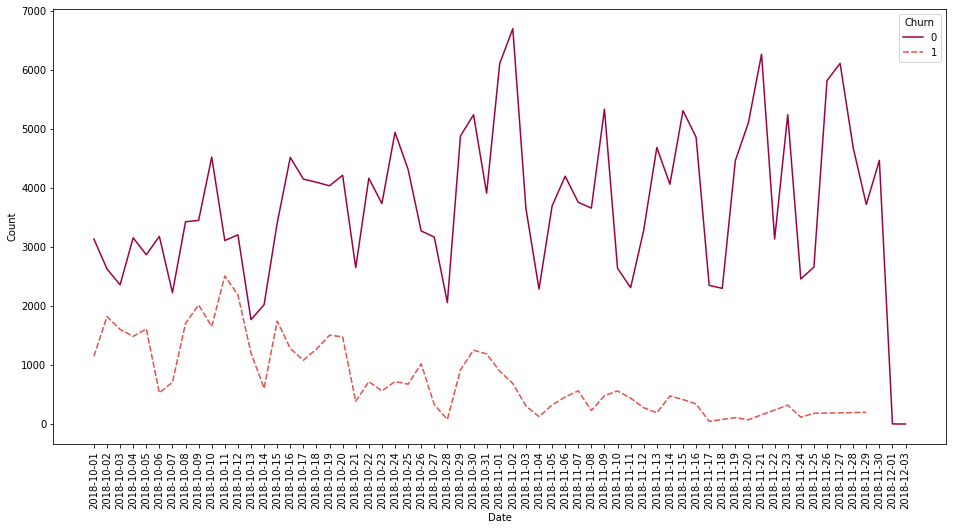

In [85]:
for i in ['churn']:
    events_per_day = df_clean.groupby('date',i).count().sort('date',i)

    plot_line_chart(events_per_day, 'date', 'count', i, line_style=i, color=colors[:2])

**Conclusion:** In the beginning of the time series, churn users display a similar pattern as non-churn users which disappears over time. It must be noted that only a short interval of 2 months can be inspected in the small dataset and due to the very definition of churn users (user canceled the service and does not produce events any more), less data points are available towards the end.

### Weekday Time Series <a class="anchor" id="weekday-time-series"></a>

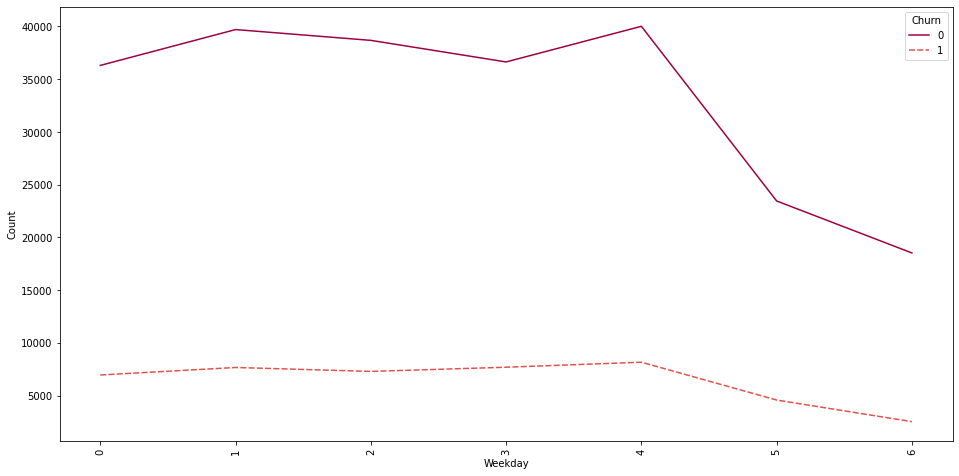

In [86]:
for i in ['churn']:
    events_per_weekday = df_clean.groupby('weekday',i).count().sort('weekday',i)

    plot_line_chart(events_per_weekday, 'weekday', 'count', i, line_style=i, color=colors[:2])

**Conclusion:** It appears that **churn users are also more active during the week (Monday - Friday) and less active during the weekend**, just as non-churn users. The difference between week and weekend is less striking though.

### Hourly Time Series <a class="anchor" id="hourly-time-series"></a>

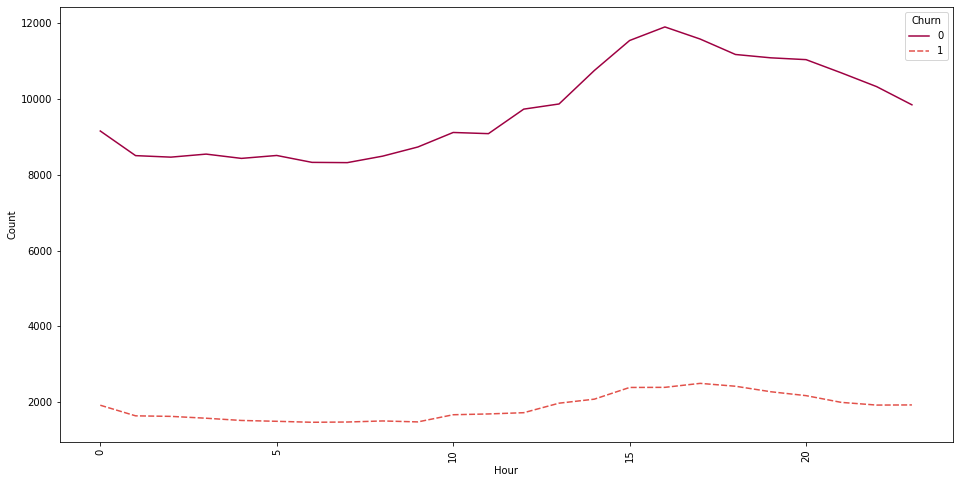

In [87]:
for i in ['churn']:
    events_per_hour = df_clean.groupby('hour',i).count().sort('hour',i)

    plot_line_chart(events_per_hour, 'hour', 'count', i, line_style=i, color=colors[:2])

**Conclusion:** It appears that **churn users are also more active during the afternoon/evening**, just as non-churn users. The difference different hours of the day is less striking though.

## Feature Engineering <a class="anchor" id="feature-engineering"></a>

Check whether churned users return. If users returned after churn, it would be important to restrict the training data to the data rows prior to the churn event because only the prior behavior should predict a following churn.

In [89]:
df_position = df_clean.withColumn('position', f.row_number()
                        .over(Window.partitionBy('userId')
                        .orderBy('ts')))

check_cancellation_position = df_position.filter(f.col('churn')==1) \
                                         .filter(f.col('page')=='Cancellation Confirmation') \
                                         .groupby('userId') \
                                         .agg({'position':'max'})
check_other_position = df_position.filter(f.col('churn')==1) \
                                  .filter(f.col('page')!='Cancellation Confirmation') \
                                  .groupby('userId') \
                                  .agg({'position':'max'})

if check_cancellation_position.join(check_other_position, on='userId',how='inner') \
                                  .withColumn('diff',check_cancellation_position['max(position)']-check_other_position['max(position)']) \
                                  .filter(f.col('diff')<0).show() == []:
    print('Churn users return.')
else: 
    print('Churn users do not return.')

+------+-------------+-------------+----+
|userId|max(position)|max(position)|diff|
+------+-------------+-------------+----+
+------+-------------+-------------+----+

Churn users do not return.


In [90]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- registration_datetime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- registration_date: string (nullable = true)
 |-- weekday: string (nullable = true)
 |-- registration_weekday: string (nullable = true)
 |-- year: string (nullable = true)
 

The following features per user are extracted in order to predict the label `churn`:

| Feature | Description | Calculation | 
| :--     | :--     | :--        |
| gender     | gender  | unique per user        |     
| browser_*     | browser  | % share over events per user        |        
| device_*     | device / operating system  | % share over events per user        |        
| page_*     | page  | % share over events per user        |        
| level_*     | level  | % share over events per user       |
| weekday_*     | weekday  | % share over events per user        |        
| day_half_*     | half of the day  | % share over events per user        |        
| sessions     | unique sessions per user  | distinct count per user       |        
| items     | total items per user  | count per user        |        
| songs     | total songs per user  | % share over total items per user        |        
| unique_songs     | unique songs per user  | % share over total songs per user        |        
| unique_artists     | unique artists per user | distinct count per user        |        
| session_length     | average length per session per user  | average over sessions per user        |        
| song_length    | average length per song per user  | average over song events per user        |        
| days_since_registration     | days since registration  | unique per user        |        

`_*` indicates originally categorical features (n levels) that are transformed into multiple columns, one per level of the respective feature because the share of every level is calculated.

### Categorical Features <a class="anchor" id="categorical-features"></a>

2-level categorical features transformed to binary integer

In [91]:
def encode_2_level(df, col_name, categories):
    '''
    Transform a 2-level categorical feature into a binary integer.
    
    Input:
    df - DataFrame: Dataframe holding the relevant categorical feature
    col_name - string: Column name for the categorical feature
    categories - list: Original levels of the categorical feature
    
    Output:
    df_encoded - DataFrame: The original dataframe with the original categorical feature replaced by the encoded feature
    '''
    df_encoded = df.select('userId', col_name) \
                   .dropDuplicates() \
                   .replace(categories, ['0', '1'], col_name)
    df_encoded = df_encoded.withColumn(col_name, df_encoded[col_name].cast(IntegerType()))
    
    return df_encoded

n-level categorical features transformed to single columns per category

In [92]:
def fan_out_categories(df, col_name):
    '''
    Transform an n-level categorical feature into n single columns containing the share of events per level grouped by user.
    
    Input:
    df - DataFrame: Dataframe holding the relevant categorical feature
    col_name - string: Column name for the categorical feature
    
    Output:
    df_fan_out - DataFrame: A new dataframe grouped by user with the original categorical feature
                            replaced by n single columns containing the share of events per level
    '''
    # list of all levels in the feature
    categories = list(df.select(col_name).dropDuplicates().toPandas()[col_name])
    
    # total events per user
    events_per_user = df.groupby('userId').count().withColumnRenamed('count', 'total_events')
    
    categories_df_list = []

    # calculate the share of each level based on the total event count per user in separate dataframes
    for c in categories:
        df_c = df.filter(f.col(col_name) == c) \
                       .groupBy('userId') \
                       .agg({col_name: 'count'}) \
                       .withColumnRenamed('count({})'.format(col_name),'count_events')
        df_c = events_per_user.join(df_c, on='userId', how='inner') \
                              .withColumn('{}_{}'.format(col_name,c.lower().replace(" ", "_")), df_c['count_events']/events_per_user['total_events']) \
                              .drop('count_events','total_events')
        categories_df_list.append(df_c)

    # select the user as base for the returned dataframe grouped by user
    df_fan_out = events_per_user.select('userId')
    
    # join all single levels containing the share of events per level
    for c in categories_df_list:
        df_fan_out = df_fan_out.join(c, on='userId', how='full')
        
    return df_fan_out

In [93]:
def calculate_categorical_features():
    '''
    Feature engineering for categorical features grouped by the user.
    Numerical transformation of all former categorical features.
    
    Output:
    categorical_features - DataFrame: A new dataframe grouped by user with all relevant numerical information extracted from 
                                      categorical features.
    '''
    # Feature GENDER
    df_gender = encode_2_level(df_clean, 'gender', ['M','F'])
    gender = df_gender.select('userId','gender').dropDuplicates()
    gender.persist()

    # Feature BROWSER
    browser = fan_out_categories(df_clean, 'browser')
    browser.persist()

    # Feature DEVICE
    device = fan_out_categories(df_clean, 'device_os')
    device.persist()

    # Feature PAGE
    # pages 'Cancellation Confirmation' & 'Cancel' must be filtered out to avoid perfect overfitting,
    # since this is the definition of churn
    page = fan_out_categories(df_clean.filter(f.col('page')!='Cancellation Confirmation')
                                      .filter(f.col('page')!='Cancel'), 'page')
    page.persist()

    # Feature LEVEL
    level = fan_out_categories(df_clean, 'level')
    level.persist()

    # Feature WEEKDAY
    weekday = fan_out_categories(df_clean, 'weekday')
    weekday.persist()

    # Feature DAY_HALF
    day_half = fan_out_categories(df_clean, 'day_half')
    day_half.persist()
    
    categorical_features = gender.join(browser,on='userId',how='inner') \
                                 .join(device,on='userId',how='inner') \
                                 .join(page,on='userId',how='inner') \
                                 .join(level,on='userId',how='inner') \
                                 .join(weekday,on='userId',how='inner') \
                                 .join(day_half,on='userId',how='inner')
    
    return categorical_features

In [94]:
categorical_features = calculate_categorical_features()

In [95]:
categorical_features.head()

Row(userId='100010', gender=1, browser_internet_explorer=None, browser_firefox=None, browser_safari=1.0, browser_chrome=None, device_os_ipad=None, device_os_x11=None, device_os_iphone=1.0, device_os_macintosh=None, device_os_windows=None, page_submit_downgrade=None, page_thumbs_down=0.013123359580052493, page_home=0.028871391076115485, page_downgrade=None, page_roll_advert=0.13648293963254593, page_logout=0.013123359580052493, page_save_settings=None, page_about=0.0026246719160104987, page_settings=None, page_add_to_playlist=0.01837270341207349, page_add_friend=0.010498687664041995, page_nextsong=0.7217847769028871, page_thumbs_up=0.04461942257217848, page_help=0.005249343832020997, page_upgrade=0.005249343832020997, page_error=None, page_submit_upgrade=None, level_free=1.0, level_paid=None, weekday_3=None, weekday_0=0.31758530183727035, weekday_5=0.15748031496062992, weekday_6=None, weekday_1=0.14435695538057744, weekday_4=0.29396325459317585, weekday_2=0.08661417322834646, day_half_1

### Numerical Features <a class="anchor" id="numerical-features"></a>

In [96]:
def calculate_numerical_features():
    '''
    Feature engineering for numerical features grouped by the user.
    KPI transformation of all numerical features.
    
    Output:
    numerical_features - DataFrame: A new dataframe grouped by user with all relevant numerical information extracted from 
                                    numerical features.
    '''
    # Feature SESSIONS
    sessions = df_clean.select('userId','sessionId') \
                       .dropDuplicates() \
                       .groupby('userId') \
                       .count() \
                       .withColumnRenamed('count','sessions')
    sessions.persist()

    # Feature ITEMS
    items = df_clean.groupby('userId') \
                    .count() \
                    .withColumnRenamed('count','items')
    items.persist()

    # Feature SONGS
    total_songs = df_clean.filter(f.col('page')=='NextSong') \
                          .groupby('userId') \
                          .count() \
                          .withColumnRenamed('count','total_songs')

    songs = items.join(total_songs, on='userId',how='inner') \
                 .withColumn('songs',total_songs['total_songs']/items['items']) \
                 .drop('items')
    songs.persist()

    # Feature UNIQUE_SONGS
    total_unique_songs = df_clean.filter(f.col('page')=='NextSong') \
                                 .select('userId','song') \
                                 .dropDuplicates() \
                                 .groupby('userId') \
                                 .count() \
                                 .withColumnRenamed('count','total_unique_songs')

    unique_songs = songs.join(total_unique_songs, on='userId',how='inner') \
                        .withColumn('unique_songs',total_unique_songs['total_unique_songs']/songs['total_songs']) \
                        .drop('songs')
    unique_songs.persist()

    # Feature UNIQUE_ARTISTS
    unique_artists = df_clean.filter(f.col('page')=='NextSong') \
                             .select('userId','artist') \
                             .dropDuplicates() \
                             .groupby('userId') \
                             .count() \
                             .withColumnRenamed('count','unique_artists')
    unique_artists.persist()

    # Feature SESSION_LENGTH
    session_length = df_clean.filter(f.col('page')=='NextSong') \
                             .groupby('userId','sessionId') \
                             .agg({'length':'sum'}) \
                             .groupby('userId') \
                             .agg({'sum(length)':'avg'}) \
                             .withColumnRenamed('avg(sum(length))','session_length')
    session_length.persist()

    # Feature SONG_LENGTH
    song_length = df_clean.filter(f.col('page')=='NextSong') \
                          .groupby('userId','song') \
                          .agg({'length':'sum'}) \
                          .groupby('userId') \
                          .agg({'sum(length)':'avg'}) \
                          .withColumnRenamed('avg(sum(length))','song_length')
    song_length.persist()

    # Feature DAYS_SINCE_REGISTRATION
    days_since_registration = df_clean.groupby('userId') \
                                      .agg({'days_since_registration':'max'}) \
                                      .withColumnRenamed('max(days_since_registration)','days_since_registration')
    days_since_registration.persist()
    
    numerical_features = sessions.join(items,on='userId',how='inner') \
                                 .join(songs,on='userId',how='inner') \
                                 .join(unique_songs,on='userId',how='inner') \
                                 .join(unique_artists,on='userId',how='inner') \
                                 .join(session_length,on='userId',how='inner') \
                                 .join(song_length,on='userId',how='inner') \
                                 .join(days_since_registration,on='userId',how='inner') \
                                 .drop('total_unique_songs','total_songs')
    
    return numerical_features

In [97]:
numerical_features = calculate_numerical_features()

In [98]:
numerical_features.head()

Row(userId='100010', sessions=7, items=381, songs=0.7217847769028871, unique_songs=0.9781818181818182, unique_artists=252, session_length=9562.985335714286, song_length=248.85091951672862, days_since_registration=55)

### Labels <a class="anchor" id="labels"></a>

In [99]:
labels = df_clean.select('userId','churn').dropDuplicates()

In [100]:
labels.head()

Row(userId='100010', churn=0)

### Merge Features & Labels <a class="anchor" id="merge-features-labels"></a>

In [101]:
# join numerical features, categorical features and labels
modeling_data = labels.join(numerical_features, on='userId', how='inner') \
                      .join(categorical_features, on='userId', how='inner') \
                      .drop('userId')

Due to lazy evaluation within the Spark framework, the extensive joining of different partial dataframes to receive the final modeling data results in long runtimes. This is one aspect which should definitely be improved for this project to scale to more features or data in the future. In order to speed up the modeling algorithms later, the final modeling data is saved as json here:

In [102]:
modeling_data.write.mode('overwrite').save('modeling_data.json',format='json',header=True)

In [103]:
modeling_data = spark.read.json('modeling_data.json')

In [104]:
modeling_data.head()

Row(browser_chrome=None, browser_firefox=None, browser_internet_explorer=1.0, browser_safari=None, churn=0, day_half_1=0.5020080321285141, day_half_2=0.4979919678714859, days_since_registration=173, device_os_ipad=None, device_os_iphone=None, device_os_macintosh=None, device_os_windows=1.0, device_os_x11=None, gender=1, items=1245, level_free=0.5550200803212851, level_paid=0.44497991967871486, page_about=None, page_add_friend=0.015261044176706828, page_add_to_playlist=0.018473895582329317, page_downgrade=0.008032128514056224, page_error=0.001606425702811245, page_help=0.004819277108433735, page_home=0.05301204819277108, page_logout=0.015261044176706828, page_nextsong=0.7566265060240964, page_roll_advert=0.06907630522088354, page_save_settings=0.001606425702811245, page_settings=0.008835341365461847, page_submit_downgrade=0.001606425702811245, page_submit_upgrade=0.0024096385542168677, page_thumbs_down=0.008835341365461847, page_thumbs_up=0.028112449799196786, page_upgrade=0.00642570281

#### Fill missing values:

In [105]:
modeling_data = modeling_data.fillna(0)

#### Assemble features in vector:

In [106]:
features = modeling_data.drop('churn').columns

assembler = VectorAssembler(inputCols=features, outputCol='features_vec')
modeling_data = assembler.transform(modeling_data)

In [107]:
modeling_data.head()

Row(browser_chrome=0.0, browser_firefox=0.0, browser_internet_explorer=1.0, browser_safari=0.0, churn=0, day_half_1=0.5020080321285141, day_half_2=0.4979919678714859, days_since_registration=173, device_os_ipad=0.0, device_os_iphone=0.0, device_os_macintosh=0.0, device_os_windows=1.0, device_os_x11=0.0, gender=1, items=1245, level_free=0.5550200803212851, level_paid=0.44497991967871486, page_about=0.0, page_add_friend=0.015261044176706828, page_add_to_playlist=0.018473895582329317, page_downgrade=0.008032128514056224, page_error=0.001606425702811245, page_help=0.004819277108433735, page_home=0.05301204819277108, page_logout=0.015261044176706828, page_nextsong=0.7566265060240964, page_roll_advert=0.06907630522088354, page_save_settings=0.001606425702811245, page_settings=0.008835341365461847, page_submit_downgrade=0.001606425702811245, page_submit_upgrade=0.0024096385542168677, page_thumbs_down=0.008835341365461847, page_thumbs_up=0.028112449799196786, page_upgrade=0.00642570281124498, 

## Modeling <a class="anchor" id="modeling"></a>

#### Instantiate classifiers:

In [108]:
lr = LogisticRegression(featuresCol='features_vector_scaled', labelCol='churn')
rf = RandomForestClassifier(featuresCol='features_vector_scaled', labelCol='churn')
gbt = GBTClassifier(featuresCol='features_vector_scaled', labelCol='churn')

#### Instantiate feature scaler:

In [109]:
scaler = MinMaxScaler(inputCol='features_vec', outputCol='features_vector_scaled')

#### Prepare training & prediction:
Using a pipeline containing the scaler and the classifier, data leakage from the scaling step is prevented.

In [110]:
def train_model(clf, train, scaler, file_name):
    '''
    Machine learning pipeline to train a classifier on training data with previous scaling of all features.
    The resulting model is saved in a file.
    
    Input:
    clf - instantiated estimator
    train - DataFrame: Training data containing all features and the label
    scaler - instantiated transformer
    file_name - string: File name for saving the resulting model
    
    Output:
    model - Resulting model
    '''
    # set up pipeline with scaler & classifier
    pipeline = Pipeline(stages=[scaler, clf])
    
    # train
    t0 = time()
    model = pipeline.fit(train)
    print('Training time: {}s'.format('{:.2f}'.format(time() - t0)))
    
    # save model
    model.stages[-1].write().overwrite().save(file_name)
    
    return model
    
def test_model(model, test):
    '''
    Predict labels using a classification model on the testing data.
    
    Input:
    model - Resulting model from machine learning pipeline
    test - DataFrame: Testing data containing all features and the label
    
    Output:
    pred - DataFrame: Prediction object used for model evaluation
    '''
    # predict
    t0 = time()
    pred = model.transform(test)
    print('Prediction time: {}s'.format('{:.2f}'.format(time() - t0)))
    
    return pred

#### Prepare evaluation:

In [111]:
def evaluate_model(pred_df, pred_col, true_col, clf_name):
    '''
    Evaluate prediction from a model using testing data. The relevant metrics are f1 score and accuracy.
    
    Input:
    pred_df - DataFrame: A dataframe resulting from prediction using testing data
    pred_col - string: Column name containing predicted labels
    true_col - string: Column name containing true labels
    clf_name - string: Classifier name for reference in the resulting dictionary
    
    Output:
    evaluation_dict - dict: Evaluation dictionary containing the metrics f1 and accuracy for a specified classifier
    '''
    evaluation_dict = {}
    
    # initialize
    evaluator = MulticlassClassificationEvaluator(labelCol=true_col)
    
    # calculate metrics
    accuracy = evaluator.evaluate(pred_df.select(true_col,pred_col), {evaluator.metricName: 'accuracy'})
    f1 = evaluator.evaluate(pred_df.select(true_col,pred_col), {evaluator.metricName: 'f1'})
    
    evaluation_dict['accuracy'] = accuracy
    evaluation_dict['f1'] = f1
    evaluation_dict['clf'] = clf_name

    print('Accuracy: {}%'.format('{:.0f}'.format(accuracy*100)))
    print('F1 Score: {}%'.format('{:.0f}'.format(f1*100)))
    
    return evaluation_dict

In [112]:
def compare_evaluated_models(evaluation_list):
    '''
    Plot a comparison of all evaluated models along the relevant metrics f1 score and accuracy.
    
    Input:
    evaluation_list - list: A list containing all evaluation dictionaries. One dictionary per evaluated model.
    '''
    # merge evaluations
    evaluations = {}
    for k in evaluation_list[0].keys():
      evaluations[k] = tuple(evaluations[k] for evaluations in evaluation_list)

    # transform to pandas dataframe
    evaluations = pd.DataFrame.from_dict(evaluations)

    # figure settings
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,8), sharey=True)

    ax1 = sns.barplot(ax=ax1, x=evaluations['clf'], y=evaluations['f1'], palette=colors)
    ax1.set(xlabel='Classifier'.replace('_',' ').title(), ylabel='f1'.replace('_',' ').title())
    for index, row in evaluations.iterrows():
        ax1.text(row.name, row.f1+0.01, '{:.0f}'.format(row.f1*100)+'%', color='black', ha='center')

    ax2 = sns.barplot(ax=ax2, x=evaluations['clf'], y=evaluations['accuracy'],  palette=colors)
    ax2.set(xlabel='Classifier'.replace('_',' ').title(), ylabel='accuracy'.replace('_',' ').title())
    for index, row in evaluations.iterrows():
        ax2.text(row.name, row.accuracy+0.01, '{:.0f}'.format(row.accuracy*100)+'%', color='black', ha='center')

    plt.show()   

#### Split Train & Test Sets:

In [113]:
# split data into train and test set
train, test = modeling_data.randomSplit([0.8, 0.2], seed=31)

### Logistic Regression<sup>3</sup> <a class="anchor" id="logistic-regression"></a>

In [114]:
lr_model = train_model(lr, train, scaler, 'lr.model')

Training time: 9.23s


### Random Forest Classifier <a class="anchor" id="random-forest-classifier"></a>

In [115]:
rf_model = train_model(rf, train, scaler, 'rf.model')

Training time: 5.66s


### Gradient-Boosted Tree Classifier <a class="anchor" id="gradient-boosted-tree-classifier"></a>

In [116]:
gbt_model = train_model(gbt, train, scaler, 'gbt.model')

Training time: 19.40s


### Model Comparison <a class="anchor" id="model-comparison"></a>

Prediction time: 0.09s
Accuracy: 88%
F1 Score: 88%


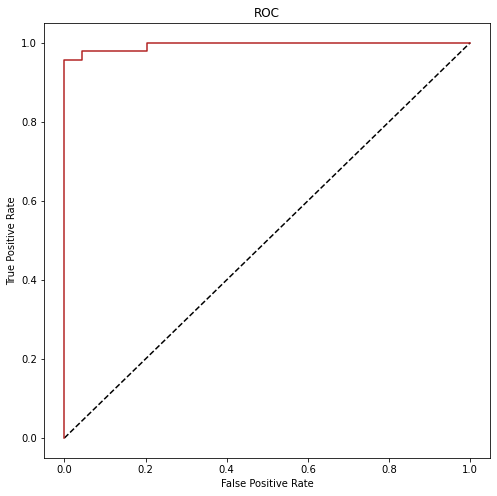

In [117]:
lr_pred = test_model(lr_model, test)
lr_evaluation = evaluate_model(lr_pred,'prediction','churn','Logistic Regression')

plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(lr_model.stages[-1].summary.roc.select('FPR').collect(),
         lr_model.stages[-1].summary.roc.select('TPR').collect(), color ='firebrick')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [118]:
rf_pred = test_model(rf_model, test)
rf_evaluation = evaluate_model(rf_pred,'prediction','churn','Random Forest')

Prediction time: 0.07s
Accuracy: 84%
F1 Score: 82%


In [119]:
rf_model.stages[-1].featureImportances

SparseVector(46, {0: 0.0096, 1: 0.0044, 4: 0.0199, 5: 0.0269, 6: 0.0967, 7: 0.0021, 9: 0.006, 10: 0.0065, 11: 0.0056, 13: 0.0252, 14: 0.0192, 15: 0.0019, 16: 0.0391, 17: 0.0263, 18: 0.0376, 19: 0.0423, 20: 0.004, 21: 0.0105, 22: 0.0265, 23: 0.044, 24: 0.0174, 25: 0.0518, 26: 0.0096, 27: 0.0319, 28: 0.0025, 29: 0.0178, 30: 0.0675, 31: 0.0437, 32: 0.0074, 33: 0.0077, 34: 0.0134, 35: 0.0168, 36: 0.043, 37: 0.0213, 38: 0.0371, 39: 0.0405, 40: 0.011, 41: 0.0177, 42: 0.0204, 43: 0.0339, 44: 0.0196, 45: 0.0136})

In [120]:
gbt_pred = test_model(gbt_model, test)
gbt_evaluation = evaluate_model(gbt_pred,'prediction','churn','Gradient-Boosted Tree')

Prediction time: 0.12s
Accuracy: 74%
F1 Score: 78%


In [121]:
gbt_model.stages[-1].featureImportances

SparseVector(46, {0: 0.0001, 1: 0.0, 2: 0.0069, 3: 0.0, 4: 0.0744, 5: 0.0396, 6: 0.1608, 12: 0.0081, 13: 0.0207, 14: 0.0054, 16: 0.056, 17: 0.0124, 18: 0.0555, 19: 0.0424, 20: 0.0168, 21: 0.0005, 22: 0.0172, 23: 0.0272, 24: 0.0065, 25: 0.0222, 26: 0.009, 27: 0.0132, 28: 0.0035, 29: 0.0076, 30: 0.0985, 31: 0.0326, 32: 0.0095, 33: 0.0168, 35: 0.0069, 36: 0.044, 37: 0.0094, 38: 0.0032, 39: 0.0104, 40: 0.0274, 41: 0.0107, 42: 0.0436, 43: 0.0216, 44: 0.0474, 45: 0.0121})

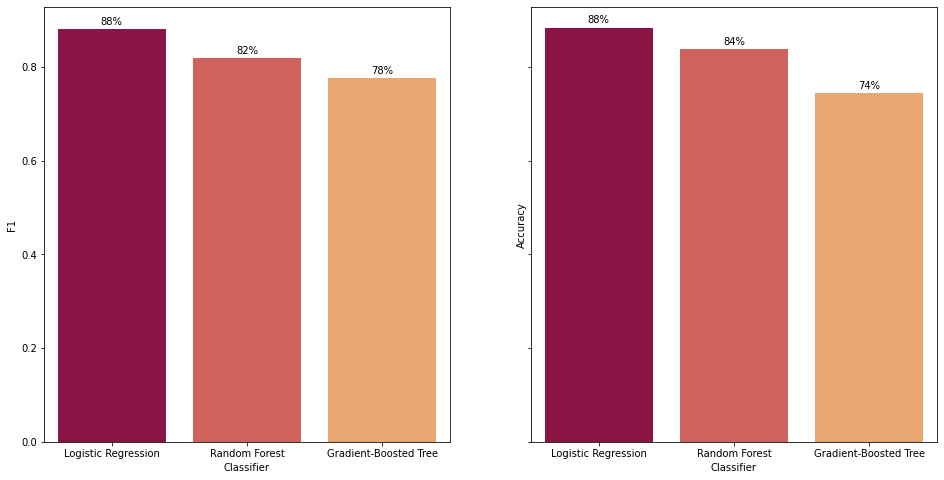

In [122]:
compare_evaluated_models([lr_evaluation, rf_evaluation, gbt_evaluation])

**Conclusion:** With default parameters, the **Logistic Regression appears to be the best performing model in terms of F1 score (88%) & accuracy (88%)**. The **Random Forest Classifier has best performance in terms of training time** with slightly lower F1 score (82%) and accuracy (84%) and could be interesting for **scaling the modeling process on big data** when performance is important.

Feature importances show that **feature 6 (days since registration) has the highest impact (random forest: 0.09, gradient-boosted tree: 0.16)**.

### Hyperparameter Tuning <a class="anchor" id="hyperparameter-tuning"></a>

#### Prepare cross-validation:

In [123]:
def tune_hyperparameters(clf, parameters, label_col, train, scaler, folds=3):
    '''
    Machine learning pipeline to train a classifier on training data with previous scaling of all features
    and hyperparameter tuning using cross-validation.
    The resulting model is saved in a file.
    
    Input:
    clf - instantiated estimator
    parameters - parameter grid
    label_col - string: Column name containing the label
    train - DataFrame: Training data containing all features and the label
    scaler - instantiated transformer
    folds - integer: Number of cross-validation folds
    
    Output:
    cv_model - Resulting conglomerate of cross-validation models
    '''
    # set up pipeline with scaler & classifier
    pipeline = Pipeline(stages=[scaler, clf])
    
    # set up cross-validation for hyperparameters
    crossval = CrossValidator(estimator=pipeline, 
                              estimatorParamMaps=parameters,
                              evaluator=MulticlassClassificationEvaluator(labelCol=label_col),
                              numFolds=folds)
    
    # train
    t0 = time()
    cv_model = crossval.fit(train)
    print('Training time: {}s'.format('{:.2f}'.format(time() - t0)))
    
    return cv_model

def test_best_model(cv_model, test, file_name):
    '''
    Predict labels using the best corss-validation classification model on the testing data.
    
    Input:
    cv_model - Resulting conglomerate of cross-validation models from machine learning pipeline
    test - DataFrame: Testing data containing all features and the label
    file_name - string: File name for saving the resulting model
    
    Output:
    best - Best cross-validation model from conglomerate
    best_pred - DataFrame: Prediction object on best cross-validation model used for model evaluation
    '''
    best = cv_model.bestModel
    
    # predict
    t0 = time()
    best_pred = best.transform(test)
    print('Prediction time: {}s'.format('{:.2f}'.format(time() - t0)))
    
    # save model
    best.write().overwrite().save(file_name)
    
    return best, best_pred

### Logistic Regression - CV <a class="anchor" id="logistic-regression-cv"></a>

#### Calculation of balancing ratio for label weights in logistic regression<sup>4</sup>:
Due to the imbalanced label `churn` in the dataset.

In [125]:
count_negatives = modeling_data.filter(f.col('churn')==0).count()
count_dataset = modeling_data.count()
balancing_ratio= count_negatives/count_dataset
print('Balancing Ratio = {}'.format(balancing_ratio))

Balancing Ratio = 0.7688888888888888


In [127]:
train = train.withColumn('label_weights', f.when(train.churn == 1, balancing_ratio).otherwise(1-balancing_ratio))
train.select('churn','label_weights').dropDuplicates().show()

+-----+-------------------+
|churn|      label_weights|
+-----+-------------------+
|    1| 0.7688888888888888|
|    0|0.23111111111111116|
+-----+-------------------+



#### Re-Instantiate classifier using weightCol:

In [128]:
lr = LogisticRegression(featuresCol='features_vector_scaled', labelCol='churn', weightCol='label_weights')

In [129]:
lr_paramGrid = ParamGridBuilder().addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0]) \
                                 .addGrid(lr.regParam, [0.0, 0.05, 0.1]) \
                                 .addGrid(lr.maxIter, [10, 50, 100]) \
                                 .build()

lr_cv_model = tune_hyperparameters(lr, lr_paramGrid, 'churn', train, scaler)

Training time: 334.84s


### Random Forest Classifier - CV <a class="anchor" id="random-forest-classifier-cv"></a>

In [130]:
rf_paramGrid = ParamGridBuilder().addGrid(rf.numTrees,[10, 50, 100]) \
                                 .addGrid(rf.maxDepth, [3, 5, 10, 15]) \
                                 .addGrid(rf.maxBins, [10, 32, 50]) \
                                 .build()

rf_cv_model = tune_hyperparameters(rf, rf_paramGrid, 'churn', train, scaler)

Training time: 211.94s


### Gradient-Boosted Tree Classifier - CV <a class="anchor" id="gradient-boosted-tree-classifier-cv"></a>

In [131]:
gbt_paramGrid = ParamGridBuilder().addGrid(gbt.maxDepth,[3, 5, 10, 15]) \
                                  .addGrid(gbt.maxBins,[10, 32, 50]) \
                                  .build()
                                  
gbt_cv_model = tune_hyperparameters(gbt, gbt_paramGrid, 'churn', train, scaler)

Training time: 552.79s


### Model Comparison - CV <a class="anchor" id="model-comparison-cv"></a>

Prediction time: 0.09s
{'regParam': 0.05, 'MaxIter': 100, 'elasticNetParam': 1.0}
Accuracy: 67%
F1 Score: 72%


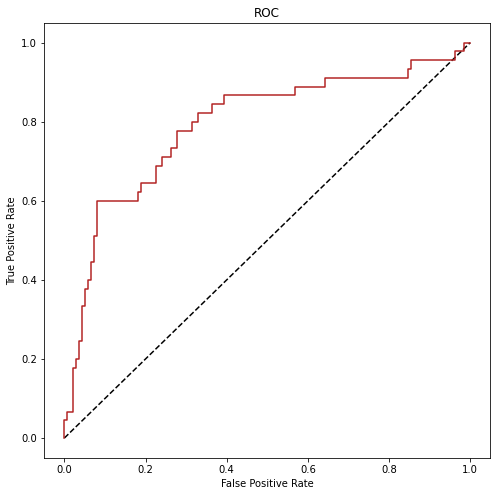

In [132]:
lr_best_model, lr_best_pred = test_best_model(lr_cv_model, test, 'lr_cv.model')
lr_best_parameters = {'regParam':lr_best_model.stages[-1]._java_obj.getRegParam(),
                      'MaxIter':lr_best_model.stages[-1]._java_obj.getMaxIter(),
                      'elasticNetParam':lr_best_model.stages[-1]._java_obj.getElasticNetParam()}
print(lr_best_parameters)
lr_best_evaluation = evaluate_model(lr_best_pred,'prediction','churn','Linear Regression')

plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(lr_best_model.stages[-1].summary.roc.select('FPR').collect(),
         lr_best_model.stages[-1].summary.roc.select('TPR').collect(), color ='firebrick')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [133]:
rf_best_model, rf_best_pred = test_best_model(rf_cv_model, test, 'rf_cv.model')
rf_best_parameters = {'numTrees':rf_best_model.stages[-1]._java_obj.getNumTrees(),
                      'maxDepth':rf_best_model.stages[-1]._java_obj.getMaxDepth(),
                      'maxBins':rf_best_model.stages[-1]._java_obj.getMaxBins()}
print(rf_best_parameters)
rf_best_evaluation = evaluate_model(rf_best_pred,'prediction','churn','Random Forest')

Prediction time: 0.08s
{'numTrees': 10, 'maxDepth': 10, 'maxBins': 32}
Accuracy: 81%
F1 Score: 78%


In [134]:
rf_best_model.stages[-1].featureImportances

SparseVector(46, {0: 0.0142, 3: 0.002, 4: 0.022, 5: 0.0213, 6: 0.0828, 9: 0.0027, 10: 0.008, 11: 0.0104, 12: 0.0061, 13: 0.0257, 14: 0.0231, 15: 0.0226, 16: 0.0102, 17: 0.0446, 18: 0.0131, 19: 0.0184, 20: 0.0088, 21: 0.0083, 22: 0.0212, 23: 0.019, 24: 0.031, 25: 0.0498, 26: 0.0143, 27: 0.0308, 28: 0.0055, 29: 0.0217, 30: 0.0506, 31: 0.0554, 32: 0.0007, 33: 0.0159, 34: 0.0281, 35: 0.0075, 36: 0.0392, 37: 0.0422, 38: 0.0332, 39: 0.0101, 40: 0.0218, 41: 0.015, 42: 0.0303, 43: 0.0774, 44: 0.0178, 45: 0.0171})

In [135]:
gbt_best_model, gbt_best_pred = test_best_model(gbt_cv_model, test, 'gbt_cv.model')
gbt_best_parameters = {'maxDepth':gbt_best_model.stages[-1]._java_obj.getMaxDepth(),
                       'maxBins':gbt_best_model.stages[-1]._java_obj.getMaxBins()}
print(gbt_best_parameters)
gbt_best_evaluation = evaluate_model(gbt_best_pred,'prediction','churn','Gradient-Boosted Tree')

Prediction time: 0.09s
{'maxDepth': 3, 'maxBins': 10}
Accuracy: 86%
F1 Score: 86%


In [136]:
gbt_best_model.stages[-1].featureImportances

SparseVector(46, {0: 0.0055, 1: 0.0019, 3: 0.0006, 4: 0.0175, 5: 0.005, 6: 0.0564, 8: 0.004, 9: 0.0158, 10: 0.0067, 14: 0.0098, 15: 0.0209, 16: 0.0761, 17: 0.0156, 18: 0.0146, 19: 0.0497, 20: 0.0008, 22: 0.0337, 23: 0.0476, 24: 0.0231, 25: 0.0744, 26: 0.0129, 27: 0.0177, 29: 0.0257, 30: 0.0733, 31: 0.0458, 32: 0.0017, 34: 0.0324, 36: 0.027, 38: 0.0051, 40: 0.0431, 41: 0.0127, 42: 0.0647, 43: 0.0856, 44: 0.0316, 45: 0.041})

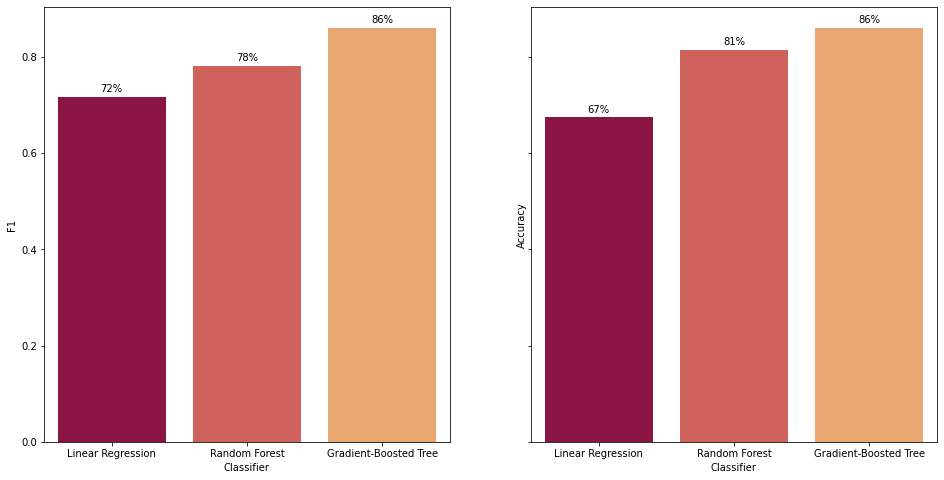

In [137]:
compare_evaluated_models([lr_best_evaluation, rf_best_evaluation, gbt_best_evaluation])

**Conclusion:** After hyperparameter tuning, the **Gradient-Boosted Tree Classifier appears to be the best performing model in terms of F1 score (86%) & accuracy 86%)**. This model takes the longest training time. The gradient-boosted tree classifier is a clearly better prediction model after hyperparameter tuning than it was before. Note that the Random Forest Classifier and especially the Linear Regression lost accuracy and performance on the F1 score after hyperparameter tuning. This could be due to overfitting on the training set using a specific combination of model hyperparameters resulting in poor prediction on the testing data.

Feature importances show that feature 6 - days since registration still has the highest impact for the  Random Forest Classifier (0.08). In the best performing **Gradient-Boosted Tree Classifier, apart from feature 6 - days since registration (0.06), three other features gain importance: 16 - page about (0.08), 25 - page roll advert (0.07) and 30 - page thumbs down (0.07).**

## Discussion <a class="anchor" id="discussion"></a>

**Result:** User churn is defined according to page type "Cancellation Confirmation". As could be shown throughout the analysis, this event occurs once per user and churn users do not return. This yields a **perfectly consistent base for building a churn prediction model**.

The best model for churn prediction is the **Gradient-Boosted Tree Classifier after hyperparameter tuning with the highest F1 score of 86%**. Furthermore, it is the worst performing model in terms of training time which could make it **harder to scale with larger datasets**.

Especially, the features **days since registration, page about, page roll advert and page thumbs down** stood out with highest impact on the prediction model. The exploratory data analysis showed less days since registration for churn users in comparison to non-churn users, indicating that **the decision to churn takes place in the first months after registration**. Users, who are already involved for a longer time period, are more likely to remain using the service. So, the business should focus on new customers to prevent churn. Not surprisingly, interactions such as seeing advertising and giving negative feedback (thumbs down) are important features when predicting churn.

The implementation of machine learning **pipelines including scaling and cross-validation reduce the risk of data leakage** at different points in the process.

**Particularities:** The perfectly consistent definition of churn users could be different in **real business use cases**. Some users might return after churn. This is tested in the analysis prior to modeling and should always serve as a check before churn prediction. Also, the definition of churn users according to the page type "Cancellation Confirmation" could be too tight in a real life scenario. Especially users who are engaging in the free service could become inactive without actually canceling. **Depending on the business goals and strategy a strict or broad churn definition could make sense.**

The label `churn` is **imbalanced** in the dataset. For logistic regression, the integration of label weights was part of the hyperparameter tuning process but did not result in an improvement of the model's prediction on the test data. Other methods in case of imbalanced labels are **under-/oversampling**. Oversampling can result in overfitting of the model, while undersampling can result in too small data subsets as would be the case with the small dataset here. When using a larger dataset, it could make sense to try an undersampling technique, if the minority group is still large enough.

Due to **lazy evaluation** within the Spark framework, the **extensive joining of different partial dataframes** to receive the final modeling data results in **long runtimes**. This is one aspect which should definitely be improved for this project to scale to more features or data in the future. In order to speed up the modeling algorithms here, the final modeling data is saved as json and loaded prior to modeling. Another advantage of this step is to back up the data.

**Improvements:** The classification models could be further improved in the **hyperparameter tuning process with extended parameter grids** to search a broader range of possible parameter combinations. 

In a business context, it probably makes sense to anticipate potential churn users early enough to initiate marketing countermeasures. Thus, this model should be **deployed in an interactive way in order to find relevant users and target them automatically with matching marketing campaigns**. In order to keep track of each **user's most current behavior, online model training could be a nice project to improve prediciton**.

## References
1 | https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/

2 | https://mungingdata.com/pyspark/udf-dict-broadcast/

3 | https://medium.com/swlh/logistic-regression-with-pyspark-60295d41221

4 | https://medium.com/@dhiraj.p.rai/logistic-regression-in-spark-ml-8a95b5f5434c